# Genomic surveillance analysis across the World

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.6.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

In [2]:
import re

In [3]:
import json, requests
import pandas as pd

In [10]:
from genomicsurveillance.misc import alias, ancestor_matrix

In [92]:
def fetch_covspectrum(country, start, key, annot='pangoLineage'):
    url = f"https://dev-lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?country={country}&dateFrom={start}&host=Human&accessKey={key}&fields=date,{annot},country"
    foo = json.loads(requests.get(url).text)['data']
    f = pd.DataFrame.from_dict(foo)
    f.date = pd.to_datetime(f.date)
    return f.pivot(index=['country','date'], columns=annot)['count'].fillna(0).astype('int')

In [5]:
countries = ['Germany', 'USA','United Kingdom','Singapore',
             'India','Australia','South Africa','Denmark',
             'France','Belgium','Israel','Spain',
            'Brazil','Japan','New Zealand','Mexico']

In [95]:
start_date="2021-11-01"
analysis_date = np.datetime64('today')
with open('var/key.txt','r') as f:
    key = f.read().strip()

## Load data
### Genomes

In [97]:
genomes = pd.concat([fetch_covspectrum(country, start_date, key, annot='pangoLineage') for country in countries])

In [99]:
genomes = genomes.reindex(pd.MultiIndex.from_product(genomes.index.levels)).fillna(0).astype('int').drop(columns=np.nan)

#### Check some fast growing lineages

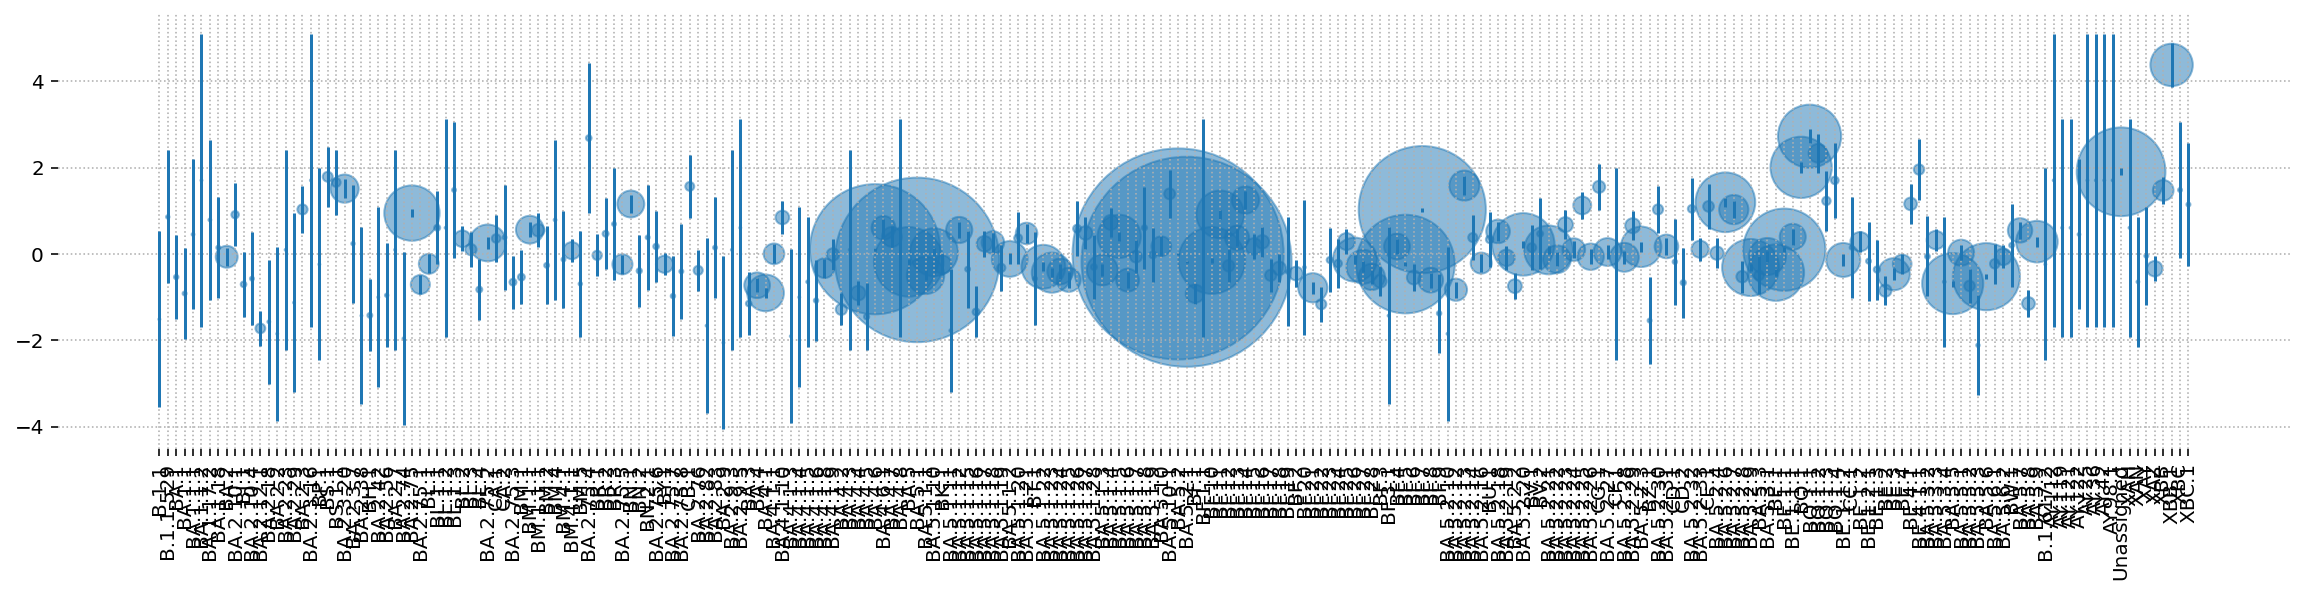

In [11]:
g = genomes.sum(level=1)
g.columns =  [alias(alias(x, anti_alias=True)) for x in g.columns]
h = g.iloc[-28:].sum(0) #+.5
i = g.iloc[-56:-28].sum(0) +.5
f = h[h>0]/i[h>0] * i.sum()/h.sum()
f.index = [alias(x, anti_alias=True) for x in f.index]
f = f.sort_index()
f.index = [alias(x) for x in f.index]
n = h[h>0]
e = np.sqrt(1./h[h>0] + 1./i[h>0] + 1./i.sum() + 1./h.sum())
#e.index = [alias(alias(x, anti_alias=True)) for x in e.index]
plt.figure(figsize=(20,4))
plt.scatter(f.index, np.log(f), s=n[f.index], alpha=0.5)
plt.errorbar(f.index, np.log(f), yerr=1.96*e[f.index], ls="")
_ = plt.xticks(rotation=90)
#plt.ylabel("14d log odds Aug 1-15 / Jul 15-30")

Text(0, 0.5, 'Fold change')

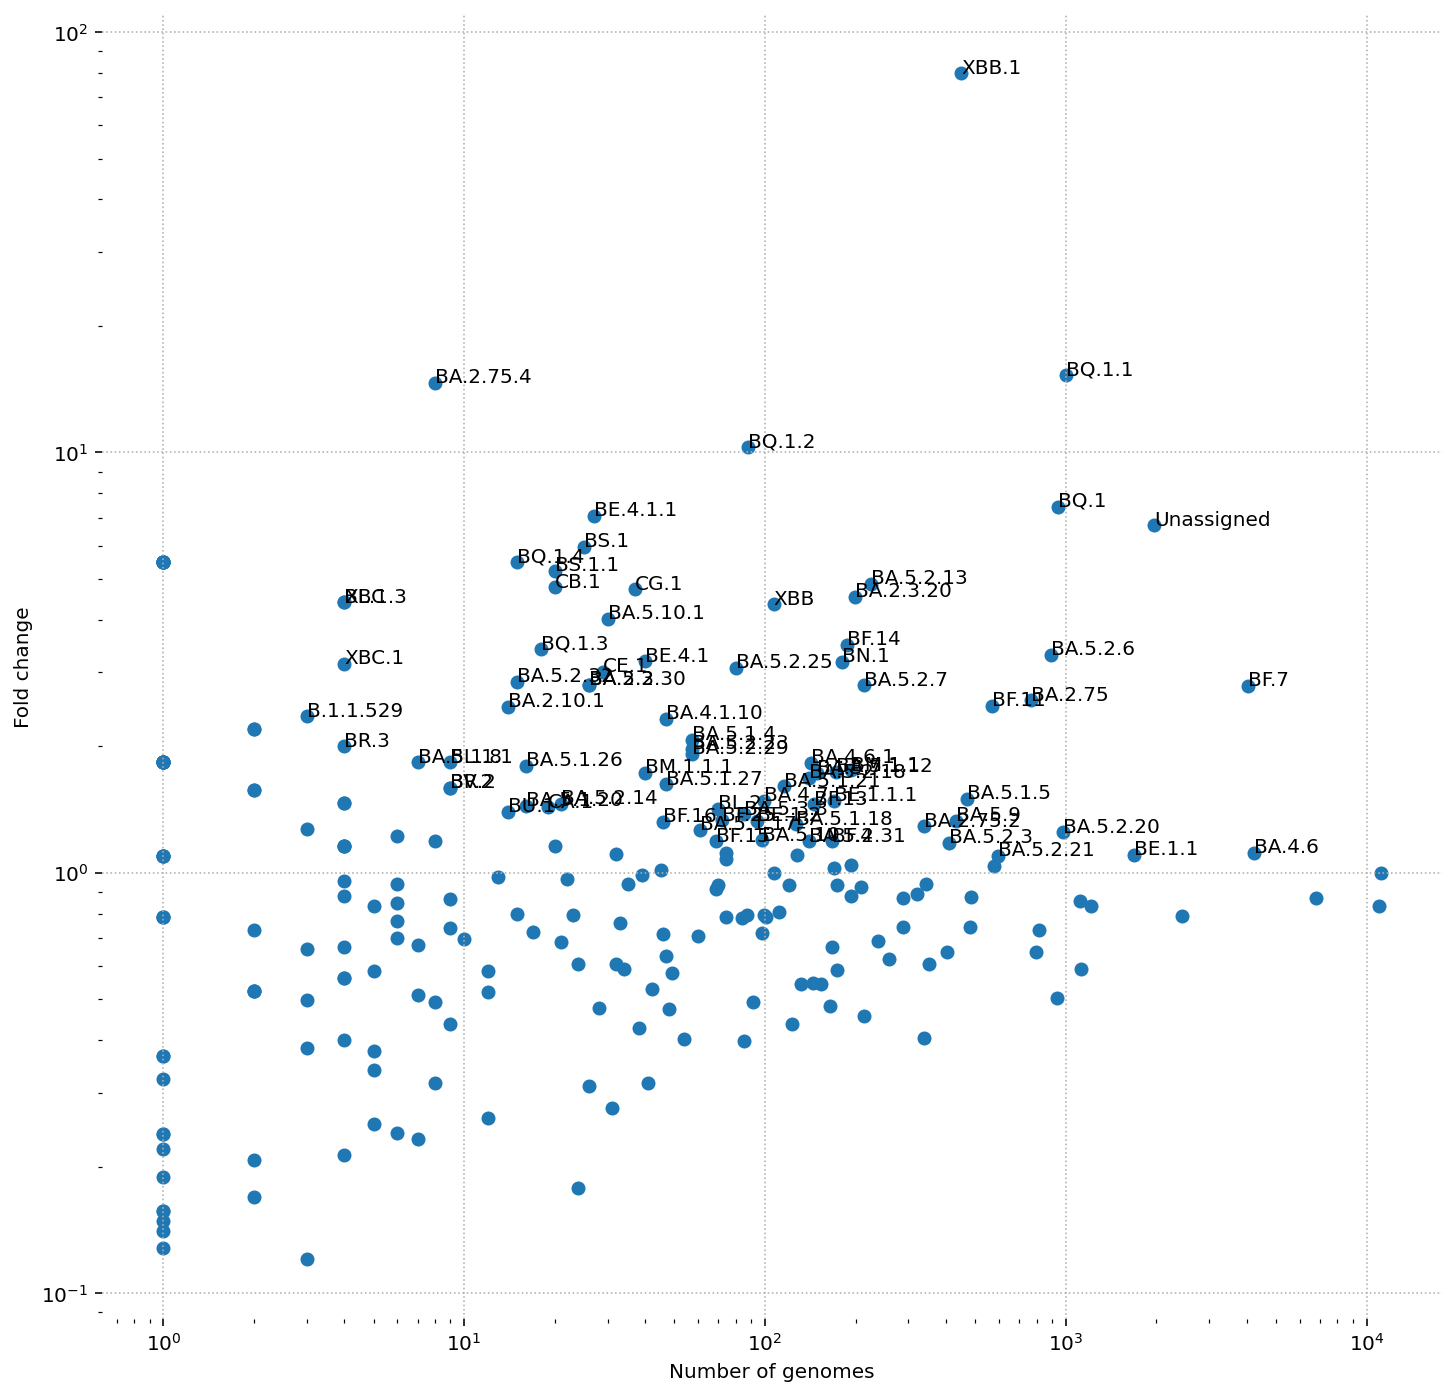

In [12]:
plt.figure(figsize=(12,12))
plt.scatter(n[f.index],f)
for l in f.index:
    if np.log(f[l]) > e[l]:
        plt.text(x=n[l], y=f[l], s=l)
plt.yscale('log')
plt.xlabel("Number of genomes")
plt.xscale('log')
plt.ylabel("Fold change")

In [107]:
alias("CG.1", anti_alias=True)

'B.1.1.529.5.2.26.1'

In [13]:
vocs = ["B.1.1.529","BA.1","BA.1.1","BA.2","BA.4","BA.5","BA.5.2","BA.5.2.6","BA.5.2.13","BA.2.12.1","BA.2.3.20","BA.2.75", "BA.2.75.1","BA.2.75.2","BA.2.75.4","BN.1","BA.4.6", "BF.7", "BF.11", "BF.14","BQ.1","BQ.1.1","BQ.1.2","XBB","XBB.1"] + ["B.1.617.2"]
#+ ["B.1.1.7","B.1.1.318","B.1.621","B.1.525","B.1.351","P.1","AY.43","AY.46.6","AY.4.2","AY.36.1"]

In [102]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])
lineages = genomes.columns.to_list()
merged_lineages, G, _ = gs.preprocess_lineage_tensor(lineage_tensor=G, 
                                                     lineage_list=[alias(x, anti_alias=True) for x in lineages], 
                                                     vocs=[alias(x, anti_alias=True) for x in lineages if x in vocs], #any([y in x for y in ["BA.4","BA.5","BA.2.12.1"]])], 
                                                     cutoff=500000)
#merged_lineages

Dropped lineages []


In [16]:
baseline = 'B.1.617.2'
o = [merged_lineages.index(x) for x in merged_lineages if x != baseline and (not x.startswith("X") or x in vocs) and not x == 'Unassigned'] + [merged_lineages.index(baseline)]
G = G[:,:,o]
merged_lineages = [merged_lineages[x] for x in o]
merged_lineages

['A',
 'B',
 'B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.3.20',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.2.75.4',
 'B.1.1.529.2.75.5.1',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.14',
 'B.1.1.529.5.2.6',
 'B.1.1.529.5.2.13',
 'B.1.1.529.5.2.33.1',
 'B.1.1.529.5.3.1.1.1.1.1',
 'B.1.1.529.5.3.1.1.1.1.1.1',
 'B.1.1.529.5.3.1.1.1.1.1.2',
 'XBB',
 'XBB.1',
 'B.1.617.2']

In [104]:
merged_lineages_alias = [alias(x) for x in merged_lineages]

In [18]:
dict(zip(merged_lineages_alias,G.sum((0,1))))

{'A': 16.0,
 'B': 10202.0,
 'B.1.1.529': 2073.0,
 'BA.1': 958226.0,
 'BA.1.1': 1099379.0,
 'BA.2': 1540085.0,
 'BA.2.3.20': 324.0,
 'BA.2.12.1': 257167.0,
 'BA.2.75': 9091.0,
 'BA.2.75.1': 3310.0,
 'BA.2.75.2': 1325.0,
 'BA.2.75.4': 164.0,
 'BN.1': 351.0,
 'BA.4': 100212.0,
 'BA.4.6': 30062.0,
 'BA.5': 429441.0,
 'BA.5.2': 457794.0,
 'BF.7': 10788.0,
 'BF.11': 1841.0,
 'BF.14': 369.0,
 'BA.5.2.6': 2061.0,
 'BA.5.2.13': 442.0,
 'CE.1': 81.0,
 'BQ.1': 1356.0,
 'BQ.1.1': 1180.0,
 'BQ.1.2': 112.0,
 'XBB': 176.0,
 'XBB.1': 465.0,
 'B.1.617.2': 1171999.0}

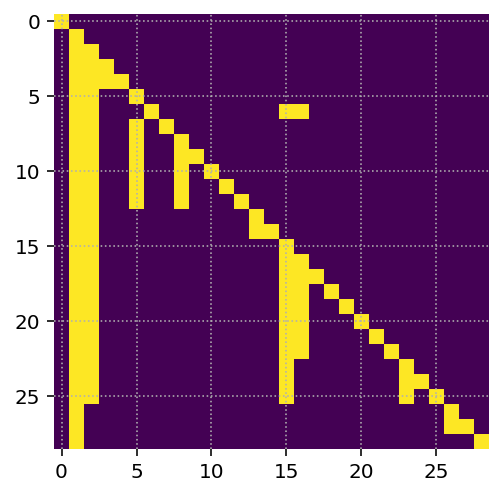

In [19]:
m = merged_lineages.copy()
m[m.index('B.1.1.529.2.3.20')] = 'B.1.1.529.5.2.20' ## Treat BA.2.3.20 as if BA.5.2 derived
#m[m.index('XBB')] = 'B.1.1.529.5.2.21' ## Treat XBB as if BA.5.2 derived
A = ancestor_matrix(m)
plt.imshow(A)

In [20]:
seq_index = np.arange(G.shape[1])

### Other parameters
We use a mock case array with constant 1000 daily cases

In [21]:
GG = G.copy() 
CC = np.ones([G.shape[0], G.shape[1]]) * 1000 ## Use fake constant case array
#CC[:, 1:-1] = np.nan #cases_land.columns.to_list().index(np.datetime64("2022-10-03"))

In [22]:
B0 = np.ones([2,G.shape[1], 2]) ## Constant basis (need 2 to preserve dimensions)
B0[1] = 0

In [23]:
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, alias

In [24]:
from numpyro.infer import Trace_ELBO

### Model
Multi-lineage model with variable growth rates (random effect) across states

In [25]:
model = MultiLineageTimeShift(
    CC,
    GG,    
    seq_index,
    np.repeat(1e6, CC.shape[0]),#np.concatenate([capita.values, capita.values.sum().reshape(1)])[[-1]],
    #auto_correlation=0.5,
    #linearize=True,
    #arma = arma2,
    b_scale=0.01,
    b0_scale=0.3,
    c_scale=5,
    c0_scale=5,
    c0_loc=-10,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.001,#.001,
    alpha1=1000., 
    #week=True,
    #fit_logits=True,#True,
    ancestor_matrix=A,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.01, 'lrd': 0.1 ** (1/10000), 'num_samples': 100, 'log_freq':500}
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=100), 'num_epochs':2000, 'lr':0.03, 'lrd': 0.5 ** (1/2000), 'num_samples': 100, 'log_freq':200}

)

In [26]:
model.fit(num_epochs=500)

SVI step 0 / 500 | 0 %


Text(0, 0.5, 'ELBO')

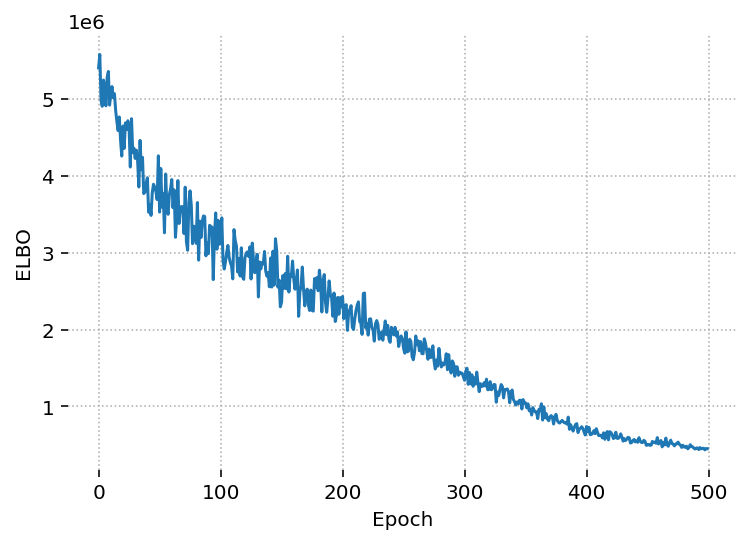

In [27]:
plt.plot(model.loss)
#plt.ylim((0,1e6))
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [28]:
model.fit(num_epochs=8000)

SVI step 0 / 8,000 | 0 %
SVI step 500 / 8,000 | 6 %
SVI step 1,000 / 8,000 | 12 %
SVI step 1,500 / 8,000 | 19 %
SVI step 2,000 / 8,000 | 25 %
SVI step 2,500 / 8,000 | 31 %
SVI step 3,000 / 8,000 | 38 %
SVI step 3,500 / 8,000 | 44 %
SVI step 4,000 / 8,000 | 50 %
SVI step 4,500 / 8,000 | 56 %
SVI step 5,000 / 8,000 | 62 %
SVI step 5,500 / 8,000 | 69 %
SVI step 6,000 / 8,000 | 75 %
SVI step 6,500 / 8,000 | 81 %
SVI step 7,000 / 8,000 | 88 %
SVI step 7,500 / 8,000 | 94 %


Text(0, 0.5, 'ELBO')

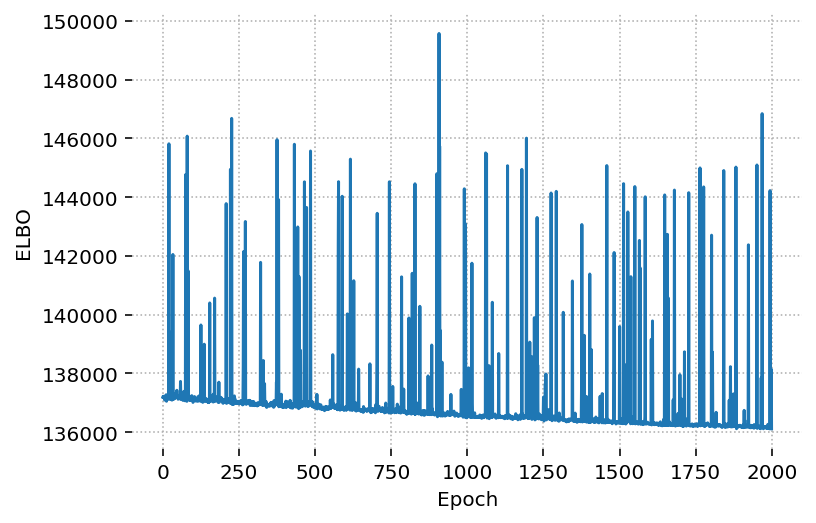

In [29]:
plt.plot(model.loss[-2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((model.loss[2000],model.loss[1200]))

### Estimated variant proportions

In [30]:
lineage_colors = {'B.1.1.529':'C7',
                 'BA.1': 'rebeccapurple',#'mistyrose', #
                 'BA.1.1': 'C4',#"lavender", #
                 'BA.2':"C1", 
                 'BA.2.12.1':"gold",
                  'BA.2.3.20':'orange',
                 'BA.2.75':"orangered",
                  'BA.2.75.1':"salmon",
                  'BA.2.75.2':"C3",
                  'BA.2.75.4':"red",
                   'BN.1':"tomato",
                 'BA.4':"C8",
                 'BA.4.6': 'peru',
                 'BA.5':"C9",
                  'BA.5.2': 'darkcyan',
                  'BA.5.2.6': 'darkturquoise',
                  'BA.5.2.13': 'cadetblue',
                  "BF.7":"limegreen",
                  'BF.11':"C2",
                  'BF.13':"yellowgreen",
                  'BF.14':'green',
                  'CE.1':'darkgreen',
                   'BQ.1':'aquamarine',
                  'BQ.1.1':'mediumspringgreen',
                  'BQ.1.2':'springgreen',
                  'XBB': 'hotpink',
                  'XBB.1':'deeppink',
                 #'Other':"C7",
                 'B.1.617.2': 'C0',
                 'AY.4.2': 'lightblue',
                  'AY.36.1': 'steelblue',
                  'AY.43': 'skyblue',
                  'AY.46.6': 'lightsteelblue',
                  'A': 'lightgrey',
                  'B': 'lightgrey',
                  'B.1.1.7': 'navy' ,
                  'B.1.351': 'black',
                  'P.1' : 'slategrey',
                  'B.1.525':'C7',
                  'B.1.1.318': 'grey',
                  'B.1.621':'grey'
                 } #"aliceblue"}

In [31]:
escape_lineages = [x for x in merged_lineages_alias if re.match("|".join(["BA.2.75", "BA.4.6","BF","BQ","BN","BA.2.3.20","CE.1","XBB"]), x)]

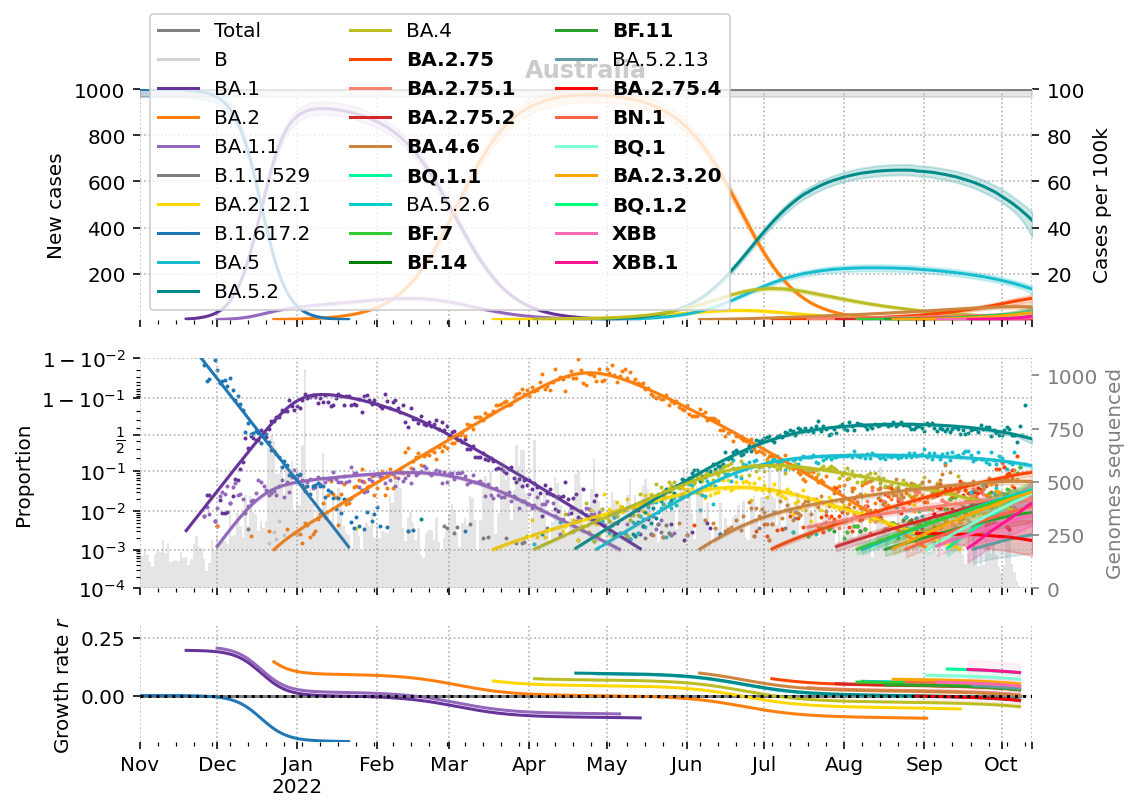

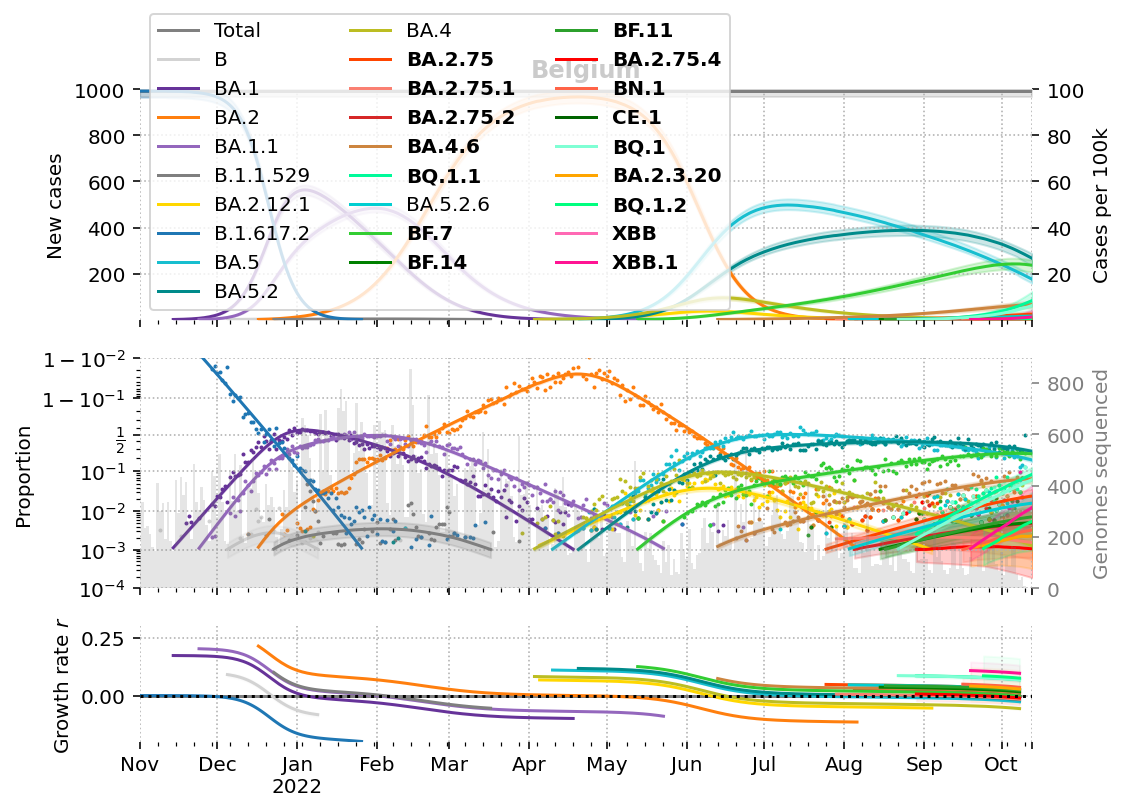

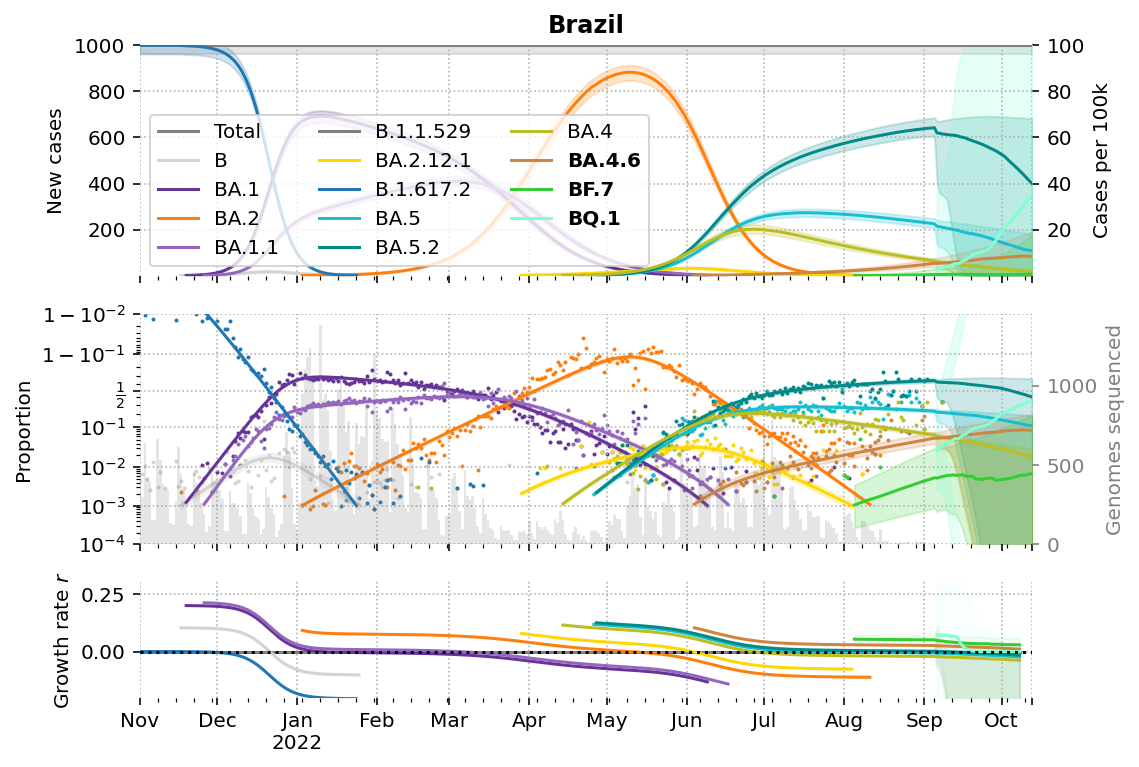

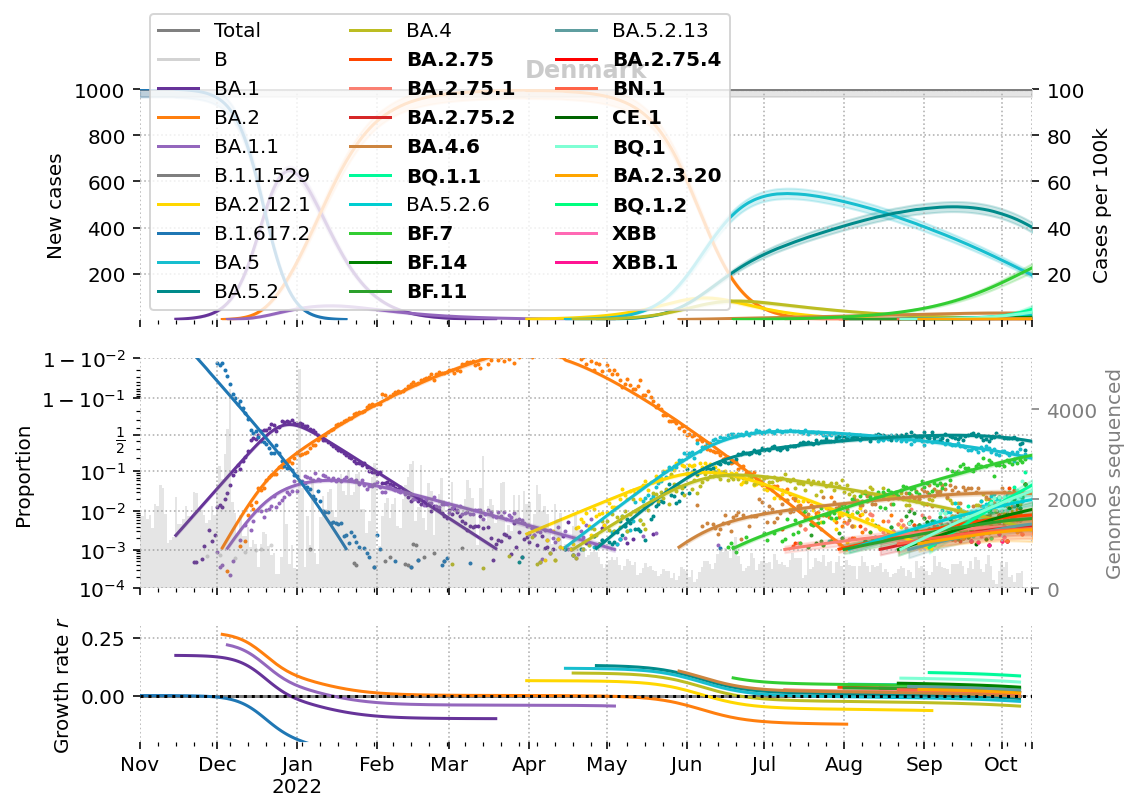

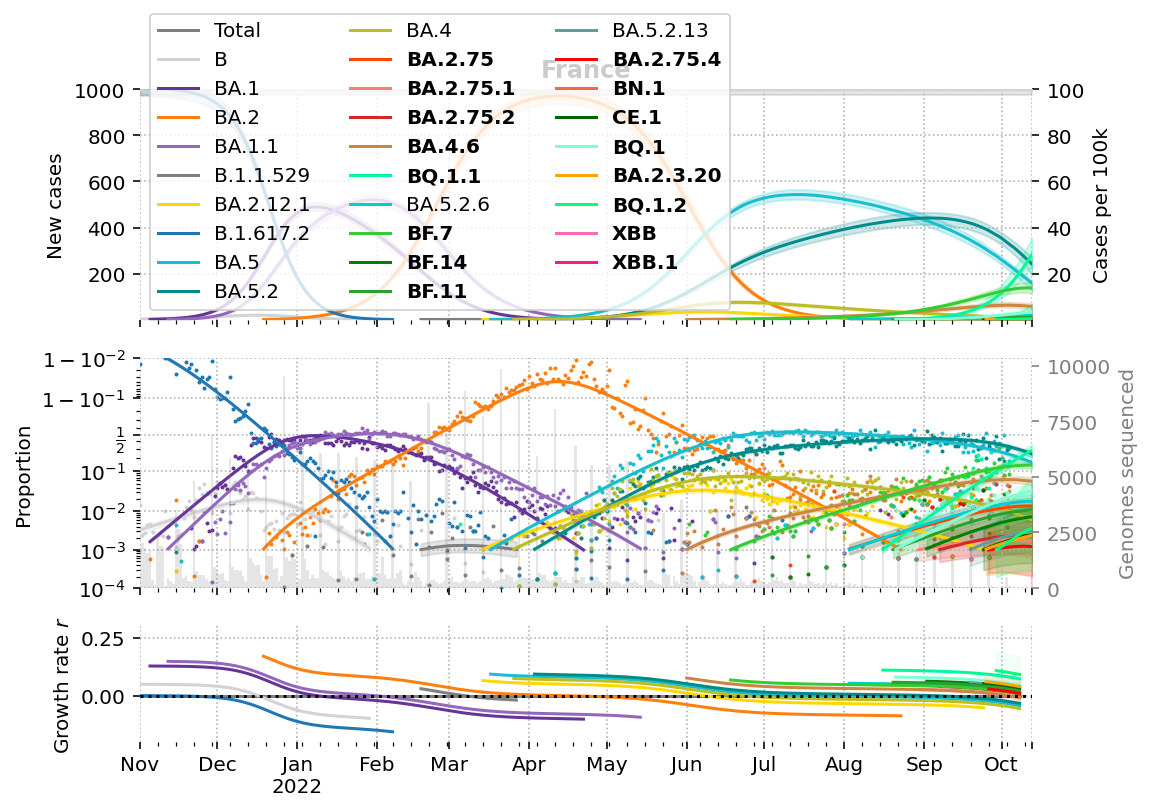

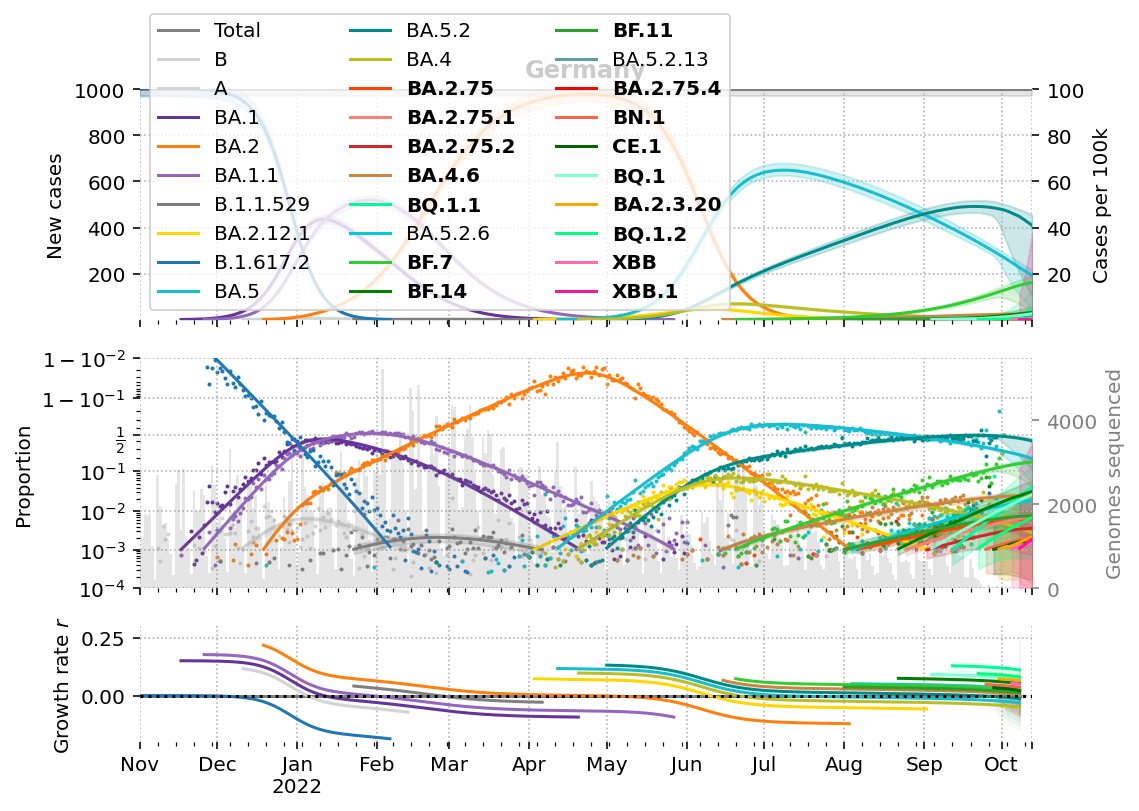

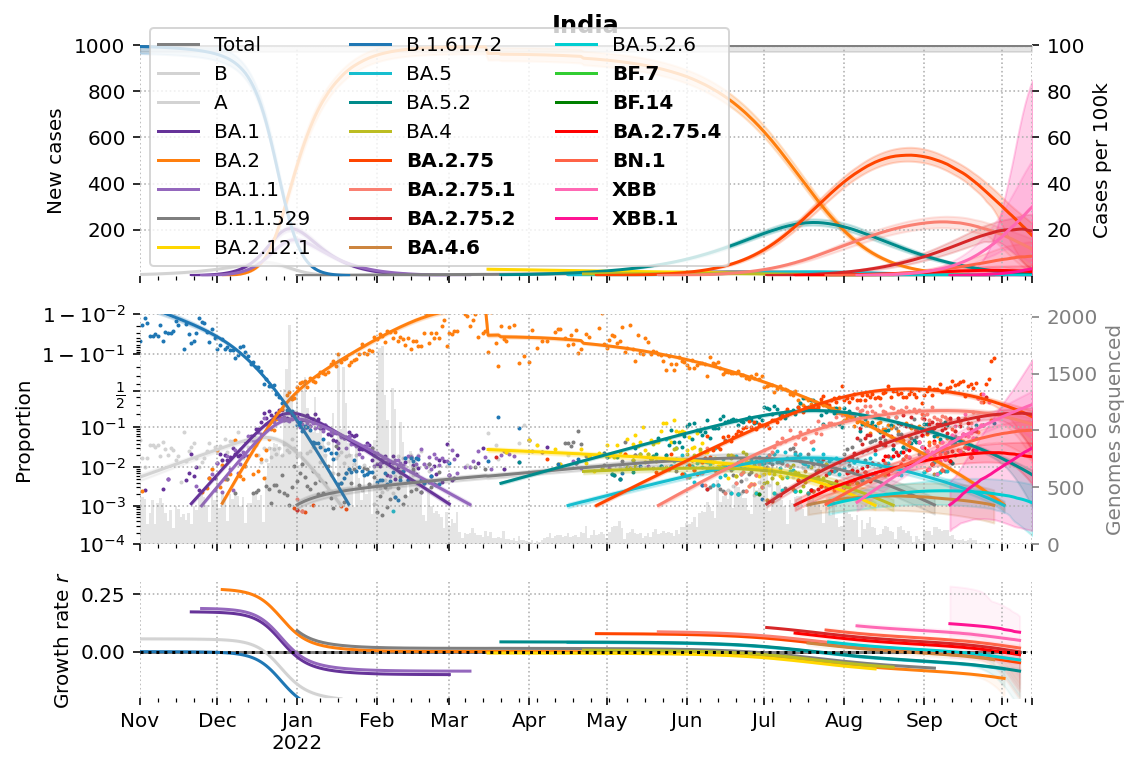

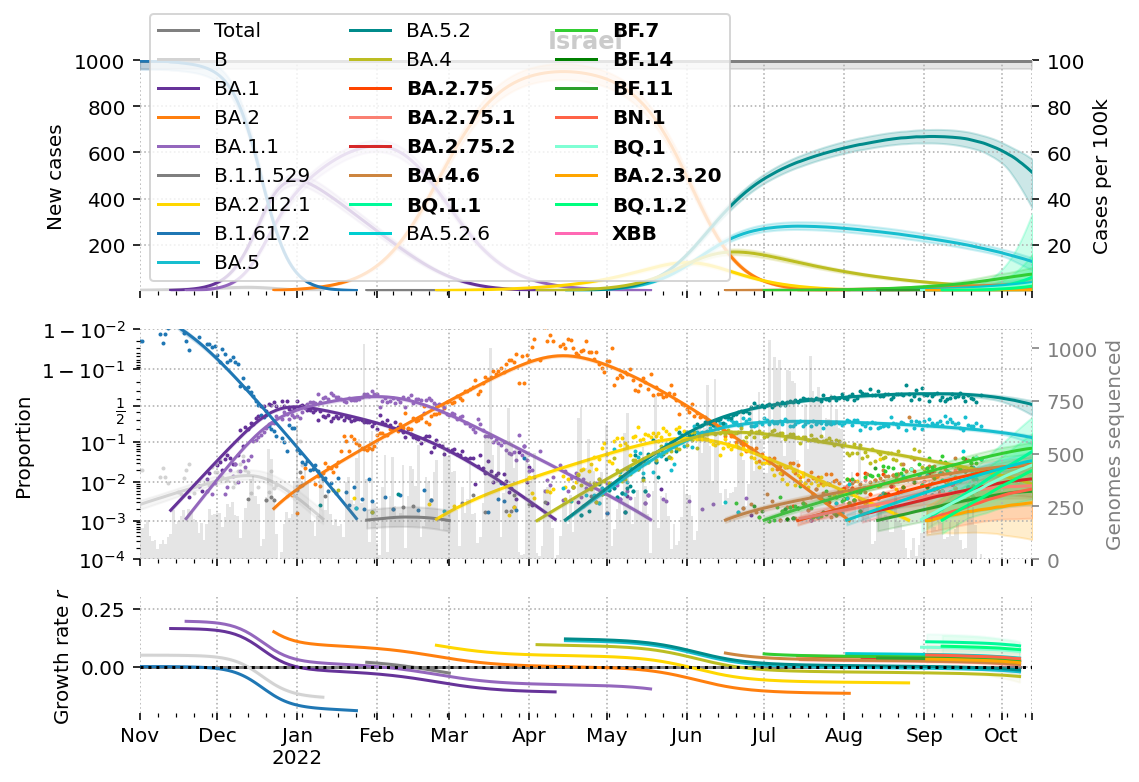

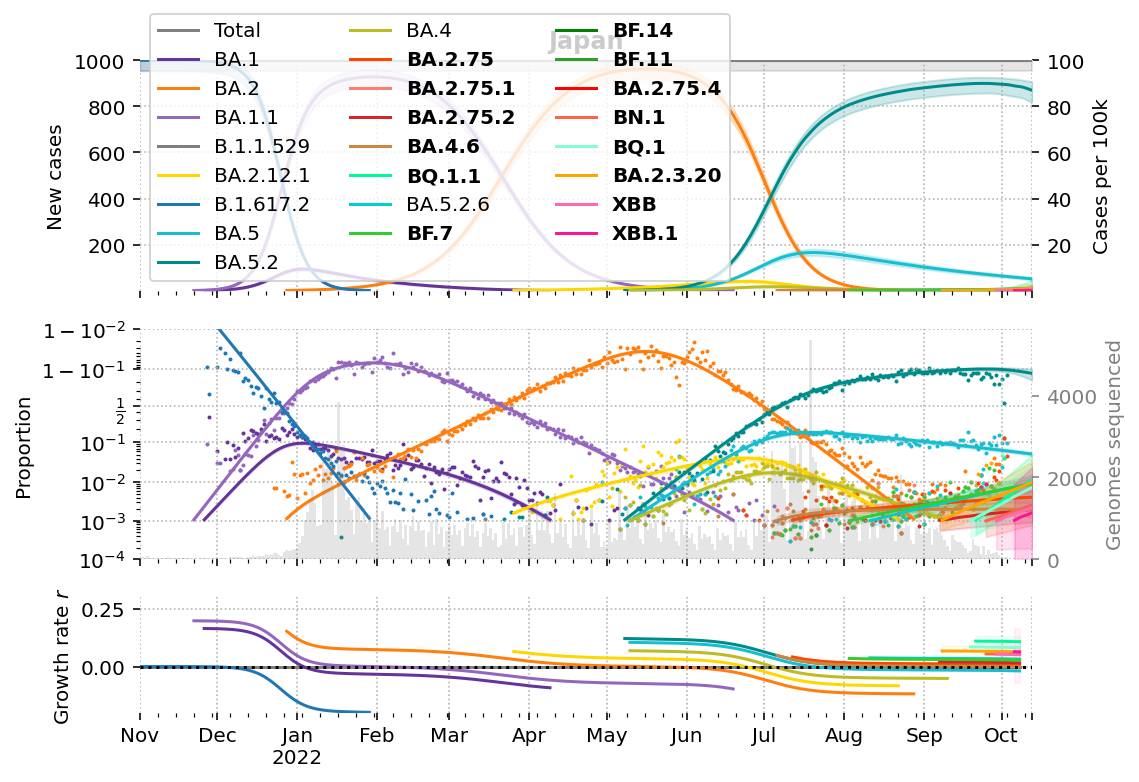

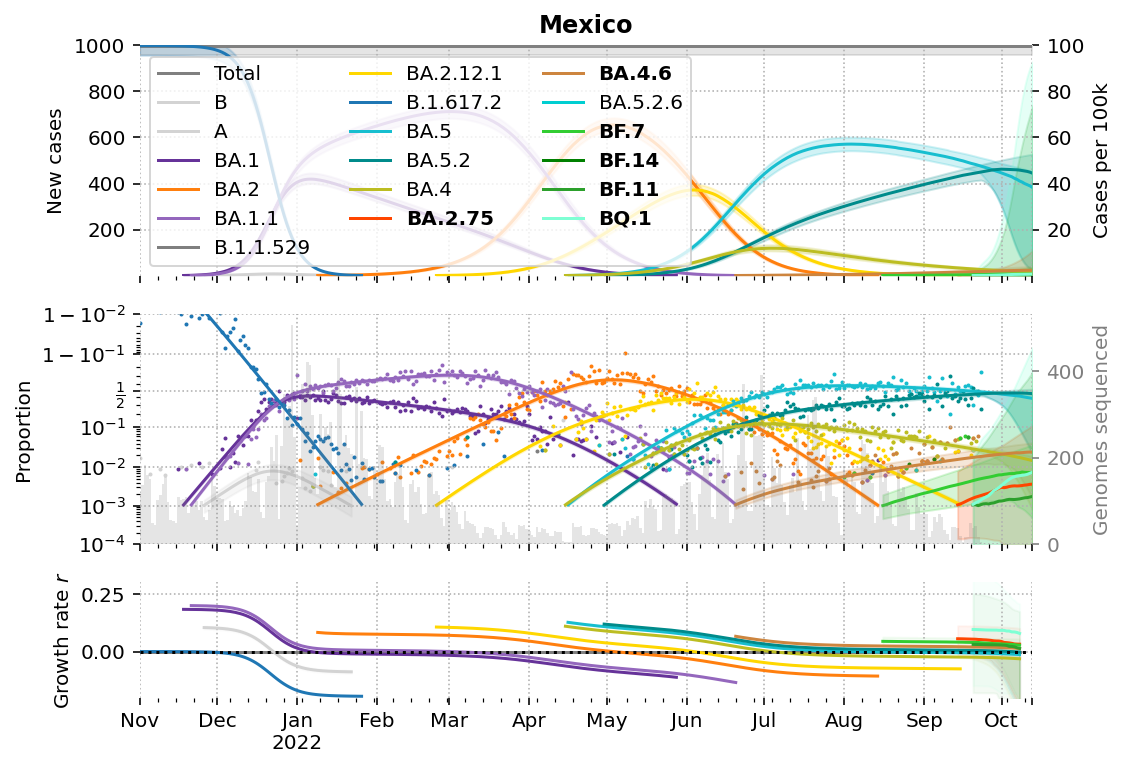

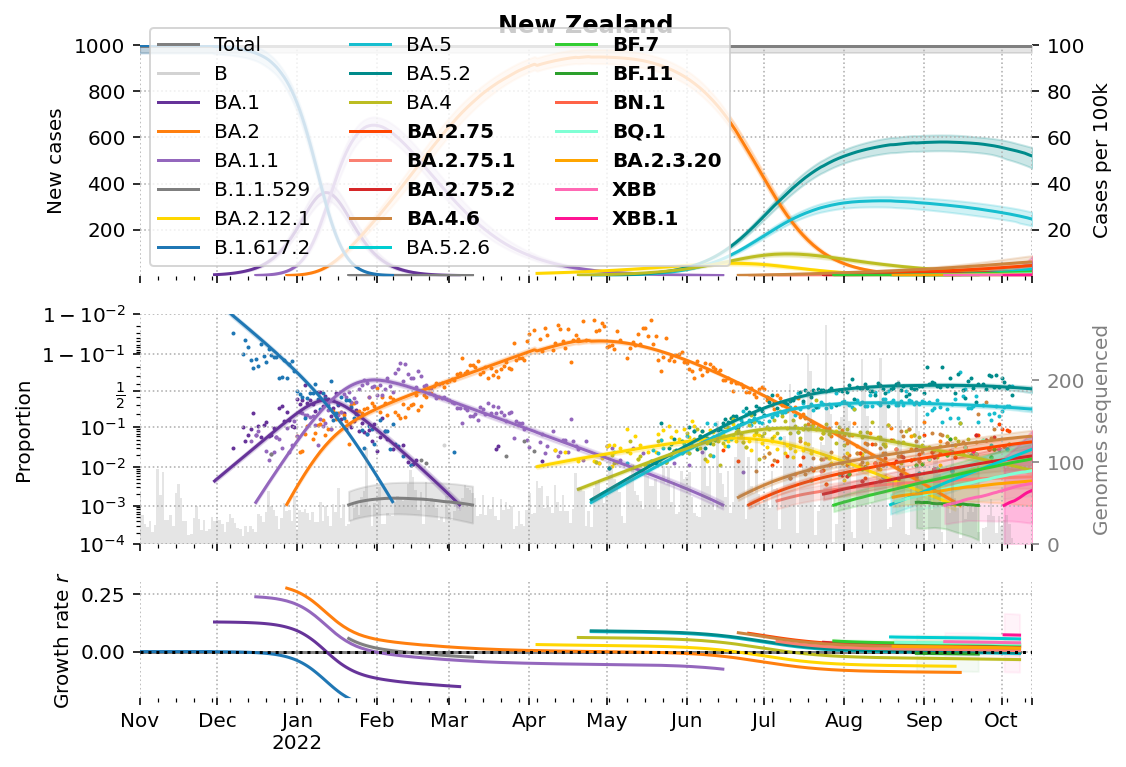

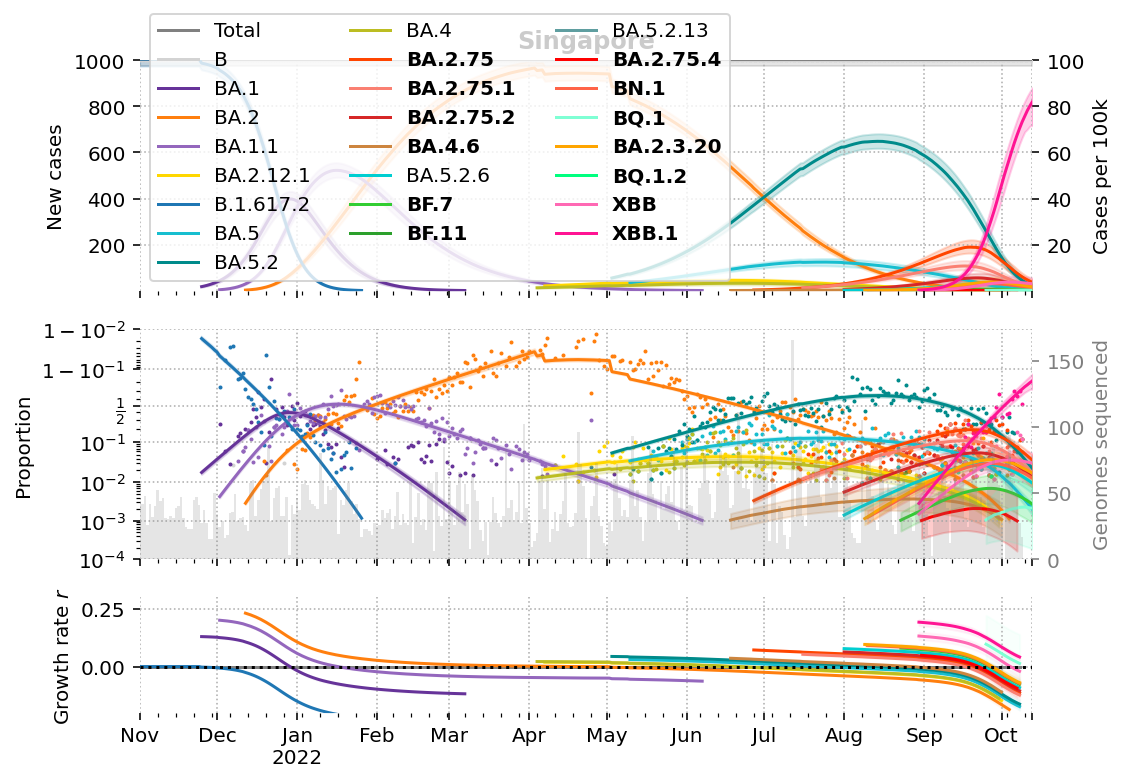

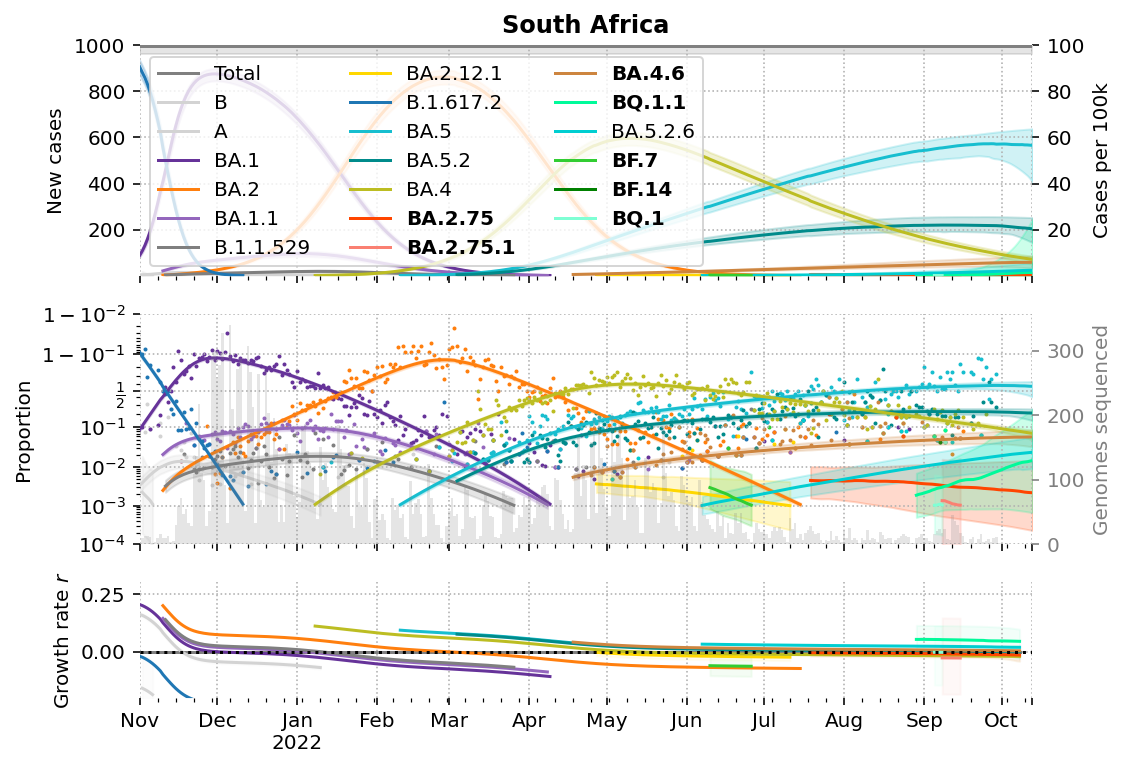

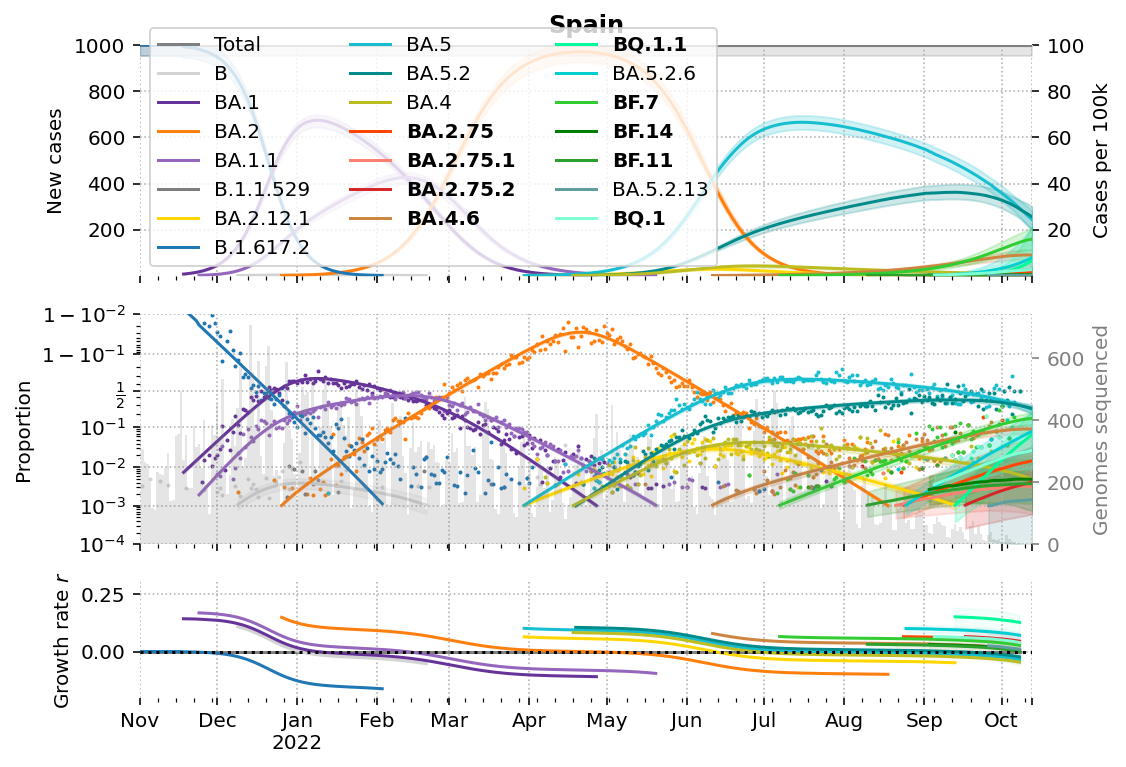

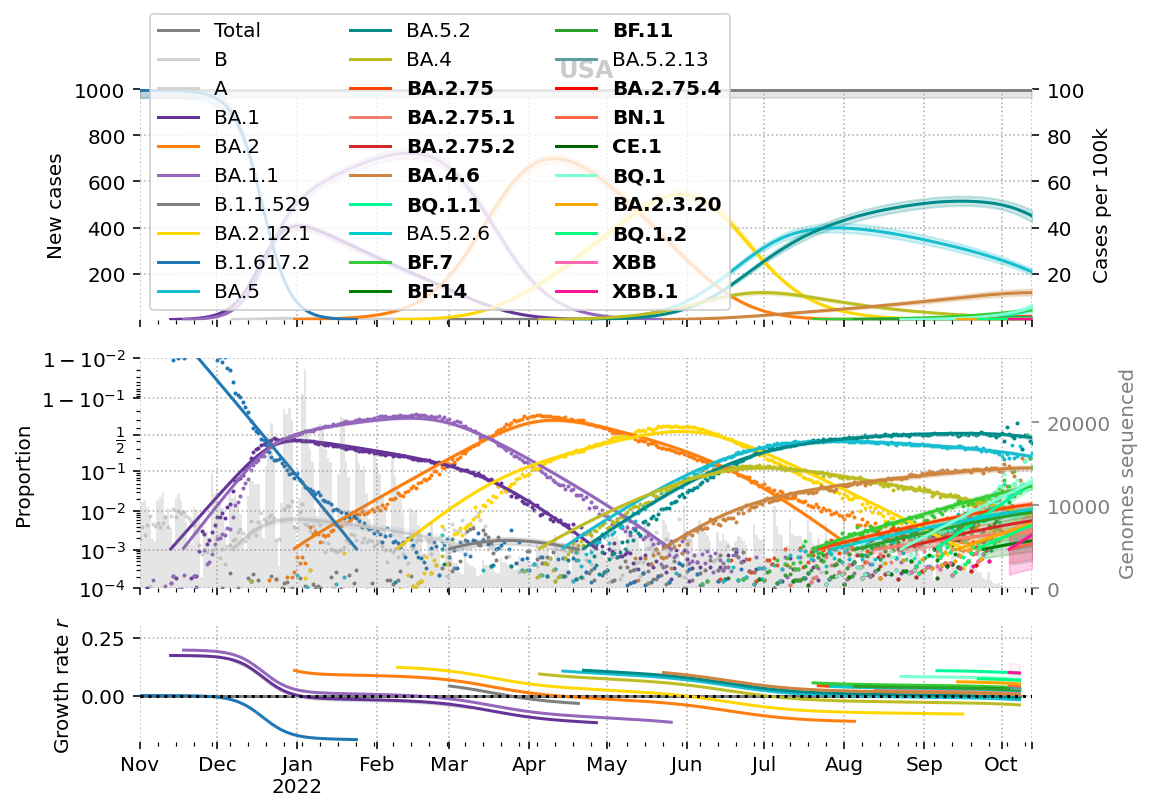

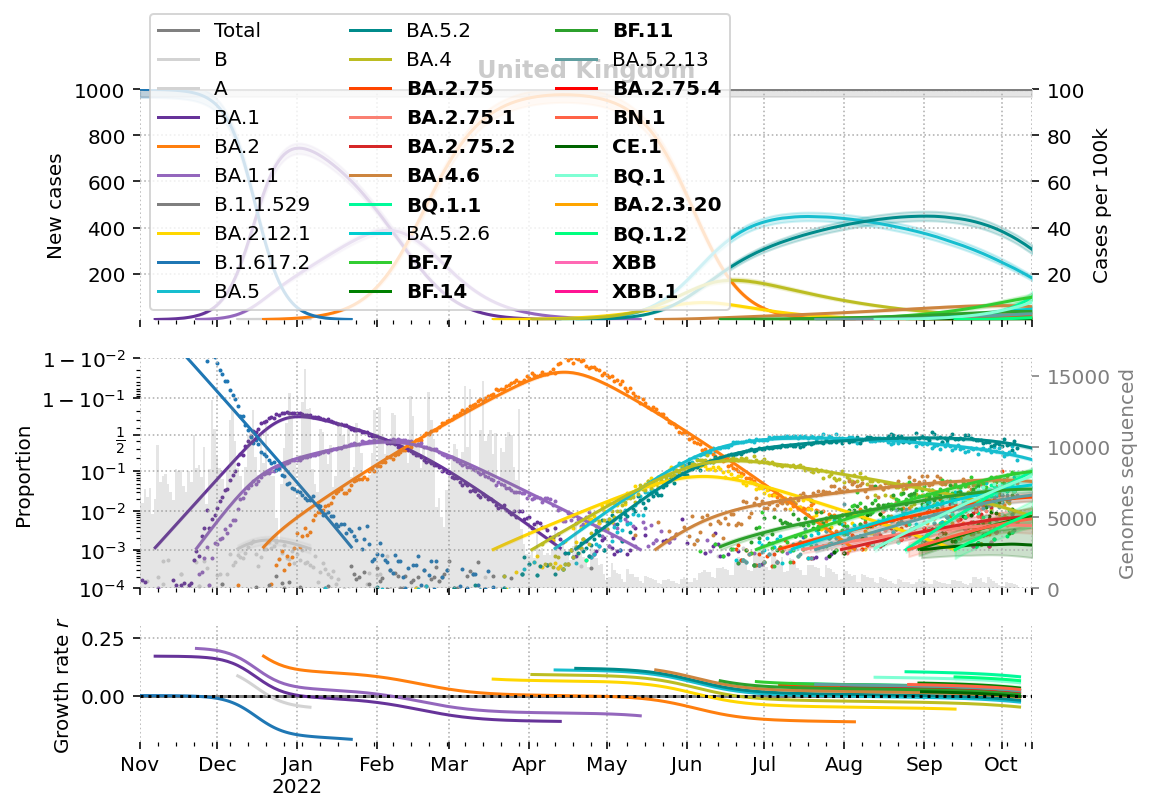

In [32]:
#from genomicsurveillance.plots.england import plot_lad, 
plt.rcParams['font.sans-serif'] = ["DejaVu Sans"]
from matplotlib import gridspec
from genomicsurveillance.plots.england import plot_median_and_ci
#from matplotlib import rc
#rc('text', usetex=False)
x = (GG.sum(0).cumsum(0)>0).argmax(0)
o = np.argsort(x + np.argsort(merged_lineages))
for i,r in enumerate(genomes.index.levels[0].to_list()): #[(-1, "Germany")]:#enumerate(cases_land.index.to_list() + ["Germany"]):
    w = o#np.where(GG[i].sum(0) >= 3)[0]
    #w = list(set(w) - set([0,GG.shape[2]-2]))
    #w = [w[-1]] + w[:-1]
    #plt.set_cmap("tab20")
    col = [lineage_colors[x] for x in merged_lineages_alias]
    plot_lad(model, i, CC, GG, seq_index, start_date=start_date, show_start_date=start_date,
        lin = w,
        labels = np.array(merged_lineages_alias)[w], #[x if not x in ["BA.2.75", "BA.4.6","BA.5.2.1.7","BA.5.2.1.11"] else r"$\bf{"+x+"}$" for x in merged_lineages_alias])[w],#genomes.columns[w],
        #lin_colors=np.array(5*['C7','C3',"C4","C1", "C6","C8" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
        lin_colors=np.array(5*col)[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
             lin_marker=".",
             lin_marker_size=2,
            figsize=(8,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    #ax[0].set_yscale('log')
    ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[0].set_ylim((None, np.nanmax(CC[i,:])))
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-4,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    #ax[2].set_xlim(("2022-06-01",None))
    #ax[0].legend("off")
    for i in range(3):
        ax[i].set_position(gridspec.GridSpec(3, 1, height_ratios=[1,1, 0.5])[i].get_position(plt.gcf()))
    #ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")
    leg = ax[0].legend(loc="lower left", ncol=3)
    for l in leg.get_texts():
        if l.get_text() in escape_lineages:
            l.set_weight('bold')
    plt.show()
    #plt.gcf().set_size_inches(12,12)

In [33]:
b = np.array(model.posterior['b1'])
b[b==0] = np.nan
b[...,-1]= 0
r = pd.DataFrame((b - b[...,[1]]).mean((0,2)), columns=merged_lineages_alias, index=genomes.index.levels[0].to_list())

### Estimated fitness effects

In [34]:
baseline = "BA.5"
show_lineages = [x for x in merged_lineages_alias if alias(x, anti_alias=True).startswith("B.1.1.529") or x in escape_lineages]
s = pd.DataFrame((b - b[...,[merged_lineages_alias.index(baseline)]]).reshape((-1,b.shape[-1])), index=pd.MultiIndex.from_product([np.arange(b.shape[0]), genomes.index.levels[0]]), columns=merged_lineages_alias)[[x for x in merged_lineages_alias if alias(x, anti_alias=True).startswith("B.1.1.529") or x in escape_lineages]].swaplevel().sort_index()#.drop(columns="BA.2.3.20")
growth_rates = (s.mean(level=0).T * 100).round().astype('Int64')
growth_rates

country    Australia  Belgium  Brazil  Denmark  France  Germany  India  \
B.1.1.529        -10      -17     -14      -15     -11      -15     -3   
BA.1             -19      -21     -19      -22     -18      -21    -14   
BA.1.1           -17      -18     -18      -16     -16      -18    -13   
BA.2              -9      -11     -11      -12      -8      -12     -4   
BA.2.3.20          7        6    <NA>        4       8       10   <NA>   
BA.2.12.1         -5       -4      -7       -5      -3       -5     -5   
BA.2.75            5        5    <NA>        4       5        4      4   
BA.2.75.1          2        1    <NA>        2       3        6      5   
BA.2.75.2          5        4    <NA>        4       5        5      9   
BA.2.75.4          0        2    <NA>        3       5        2      7   
BN.1               6        6    <NA>        3       8        7     10   
BA.4              -3       -3      -2       -2      -1       -2     -3   
BA.4.6             2        4       3        2       3        3      4   
BA.5               0        0       0        0       0        0      0   
BA.5.2             0        1       1        1       1        2      0   
BF.7               6        3       6        5       5        5     -1   
BF.11              5        5    <NA>        4       6        4   <NA>   
BF.14              0        4    <NA>        6       7        8      7   
BA.5.2.6           6        5    <NA>        5       6        6      5   
BA.5.2.13          5     <NA>    <NA>        5       8        3   <NA>   
CE.1            <NA>       -2    <NA>        2       8        6   <NA>   
BQ.1               9        9       6        8       9       10   <NA>   
BQ.1.1            12       10    <NA>       11      12       14   <NA>   
BQ.1.2             9       11    <NA>        6      13       11   <NA>   
XBB                6        5    <NA>        4       9        9     13   
XBB.1             12       13    <NA>        6      15       14     18   

country    Israel  Japan  Mexico  New Zealand  Singapore  South Africa  Spain  \
B.1.1.529     -18    -17     -18          -13       <NA>           -13    -14   
BA.1          -22    -21     -19          -26        -16           -16    -20   
BA.1.1        -19    -18     -17          -14         -9           -14    -17   
BA.2          -11    -10     -10           -9         -4            -8     -9   
BA.2.3.20       4      8    <NA>            2         10          <NA>   <NA>   
BA.2.12.1      -6     -7      -7           -6         -2            -3     -4   
BA.2.75         5      3       6            3          6            -1      7   
BA.2.75.1       3      0    <NA>            1          5            -3      4   
BA.2.75.2       4      4    <NA>            3          7          <NA>      8   
BA.2.75.4    <NA>     -2    <NA>         <NA>          7          <NA>   <NA>   
BN.1            6      7    <NA>            1         10          <NA>   <NA>   
BA.4           -2     -4      -2           -3         -2            -2     -1   
BA.4.6          3      2       3            2          2             0      4   
BA.5            0      0       0            0          0             0      0   
BA.5.2          1      2       1            0          1             0      1   
BF.7            5      5       5            4         10            -7      6   
BF.11           4      2       5            0          8          <NA>      4   
BF.14           0      0       0         <NA>       <NA>             0      4   
BA.5.2.6        6      5       1            6          8             2     11   
BA.5.2.13    <NA>   <NA>    <NA>         <NA>         15          <NA>      4   
CE.1         <NA>   <NA>    <NA>         <NA>       <NA>          <NA>   <NA>   
BQ.1            9     10      10            4         19            -2      8   
BQ.1.1         11     13    <NA>         <NA>       <NA>             4     16   
BQ.1.2         10   <NA>    <NA>         <NA>         14 

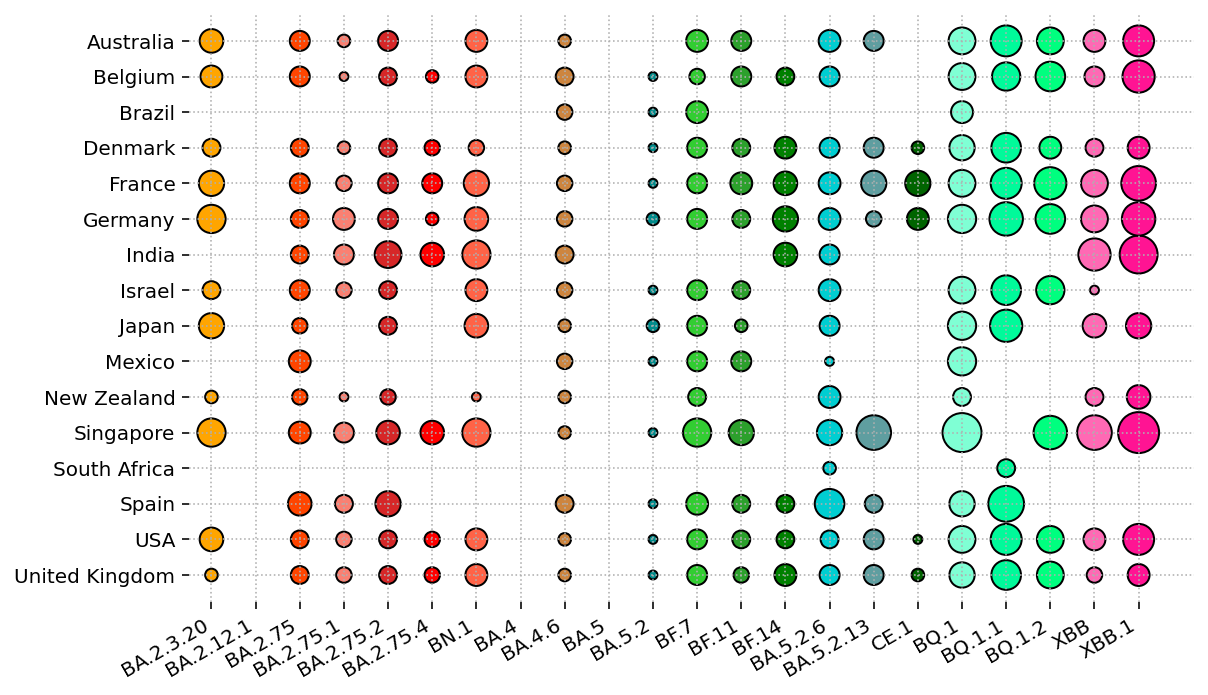

In [81]:
plt.figure(figsize=(9,6))
plt.scatter(np.tile(growth_rates.index, growth_rates.shape[1]), 
            np.repeat(growth_rates.columns[::-1], growth_rates.shape[0]),
            s=np.abs(growth_rates*((growth_rates>0)+0.0)).T.iloc[::-1]*20,
            c=np.tile([lineage_colors[x] for x in growth_rates.index], growth_rates.shape[1]),
            edgecolors='k')
plt.xlim((3.5,None))
plt.gcf().autofmt_xdate()

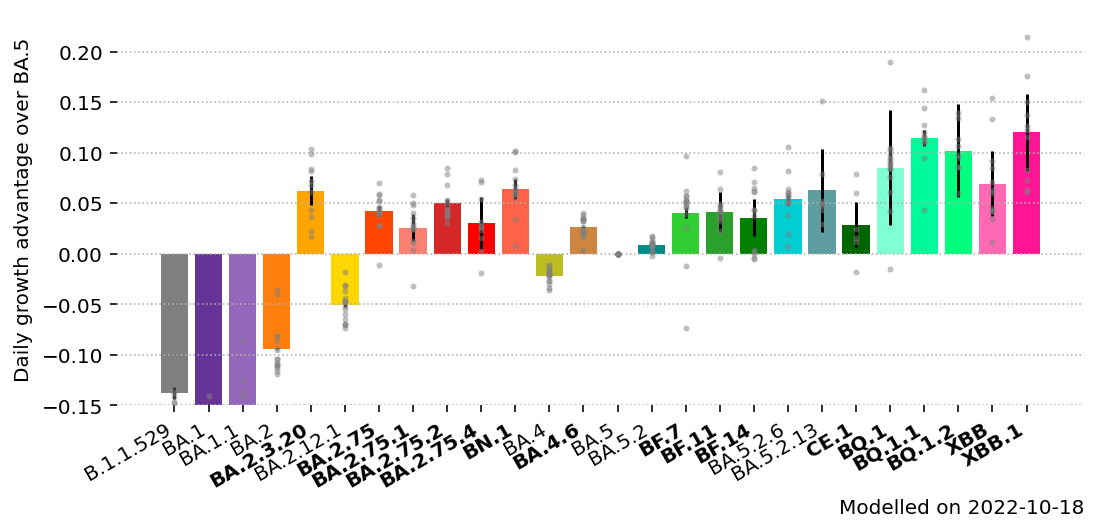

In [35]:
#s.b§oxplot()
plt.figure(figsize=(9 * s.shape[1]/27.,4))
plt.bar(s.columns, s.iloc[:-1,:].mean(), yerr=2*s.mean(level=1).std(), color=[lineage_colors[x] for x in s.columns])
#plt.errorbar(s.columns, s.iloc[:-1,:].mean(), yerr=2*s.mean(level=1).std(), ecolor='black', marker="", ls="")
plt.scatter(np.tile(s.columns, len(s.index.levels[0])), s.mean(level=0), marker='.', color='grey', zorder=10, alpha=0.5, linewidths=0) 

#plt.ylim((-0.15,0.2))
plt.ylim((-0.15,None))
#plt.draw()
#lt.xticks(rotation=45)
plt.ylabel(f"Daily growth advantage over {baseline}")
plt.grid(False)
plt.grid(axis="y")
plt.gcf().autofmt_xdate()
plt.draw()
xl = plt.gca().get_xticklabels()
for l in xl:
    if l.get_text() in escape_lineages:
        l.set_weight('bold')
plt.xlabel(f"Modelled on {analysis_date}", loc='right')
plt.gcf().savefig("plots/growth-rate-latest.png",dpi=200,bbox_inches='tight',pad_inches=0.2)


### Extrapolate variant proportions

In [36]:
from scipy.special import logit, logsumexp, softmax

In [37]:
def impute_and_extrapolate(model, future=90, time=-10, frac=0.1):    
    #time = -10 ## time point
    ll = model.get_logits()
    p = model.get_probabilities()[:,:,[time]]
    lbd = model.get_lambda()[:,:,[time]]
    p0 = (p * lbd).sum(1, keepdims=True) / lbd.sum(1, keepdims=True) + 1e-34 ## National average at i
    lg0 =logit(p0) 
    l0 = np.array(ll[:,:,[time],:])
    ls = logsumexp(l0,-1, keepdims=True)
    w = l0 < -1e-5
    l0[w] = (np.ones(l0.shape) * ls + lg0 + np.log(frac))[w] #+ np.log(1e-3)
    b1 = np.array(model.posterior['b1'])
    b1[b1==0] = np.nan
    b = np.nanmean(b1, axis=1, keepdims=True)
    b[...,-1]=0
    ll = np.concatenate([ll[:,:,:time], 
                         l0 + np.arange(1,future).reshape((1,1,-1,1)) * b] ,
                        axis=2)
    pp = softmax(ll, axis=-1)
    return pp

In [38]:
pp = impute_and_extrapolate(model, frac=0.01)

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


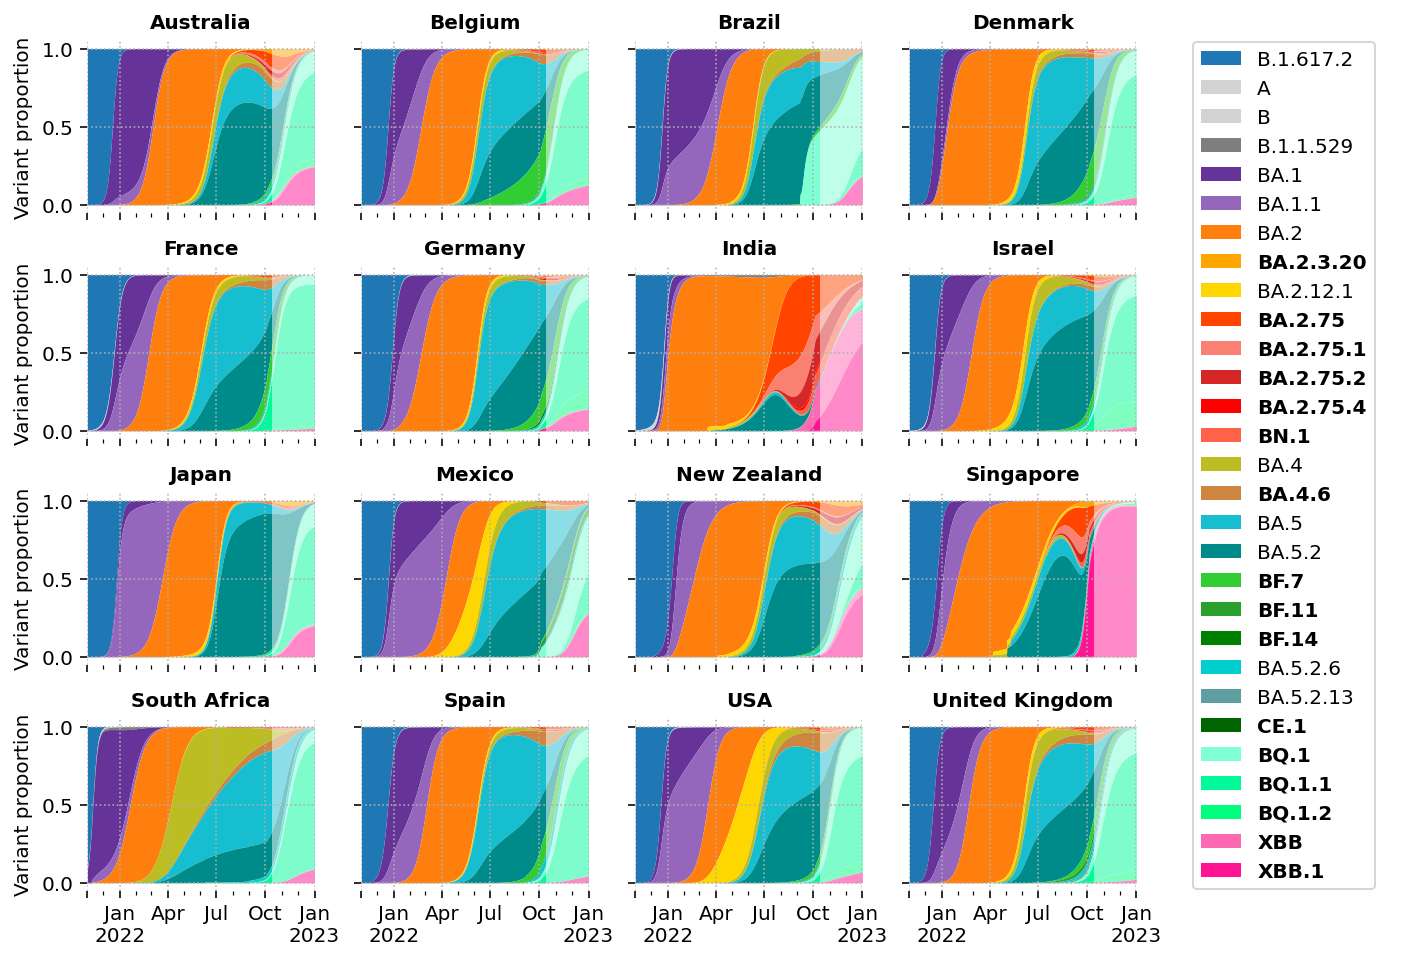

In [39]:
fig, axs = plt.subplots(4,5, figsize=(10,7), sharex=True, sharey=True)
#ax = [ax]
ax = axs[:,:-1].flatten()
#col = ['C7','C3',"C4","C1", "C6","C5","C8" ,"C9", "C7","C0"]
#labels =[alias(x) for x in merged_lineages]
col = lineage_colors #dict(zip(labels, col))
for i,r in enumerate(genomes.index.levels[0]):
    #y = pd.DataFrame(λ[i,:,:]/λ[i].sum(-1, keepdims=True), columns=merged_lineages_alias, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = pd.DataFrame(pp[:,i].mean(0).squeeze(), columns=merged_lineages_alias, index=genomes.index.levels[1][0] + np.arange(pp.shape[2]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    #y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)#* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]-1,-1,-1):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    #ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    #ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
    ax[i].axvspan(genomes.index.levels[1][-1], y.index[-1], facecolor='w',alpha=0.5, lw=0.5)
    ax[i].set_ylabel('Variant proportion')
    ax[i].set_xlim((None,"2023-01-01"))



#ax[-1].legend(loc='upper left', title=None, ncol=4)
gs = axs[0,-1].get_gridspec()
# remove the underlying axes
for a in axs[:,-1]:
    a.remove()
lax = fig.add_subplot(gs[:,-1])
lax.grid(False)
lax.axison = False
h, l = ax[i].get_legend_handles_labels()
leg = lax.legend(h,l, title=None, ncol=1, loc='center left')
for l in leg.get_texts():
    if l.get_text() in escape_lineages:
        l.set_weight('bold')
    
plt.tight_layout()
fig.savefig("plots/variant-share-latest.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [40]:
var_prop = pd.DataFrame(pp.mean(0).squeeze().reshape((-1,pp.shape[-1])), columns=merged_lineages_alias, index=pd.MultiIndex.from_product([genomes.index.levels[0],genomes.index.levels[1][0] + np.arange(pp.shape[2]).astype('timedelta64[D]')])) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700

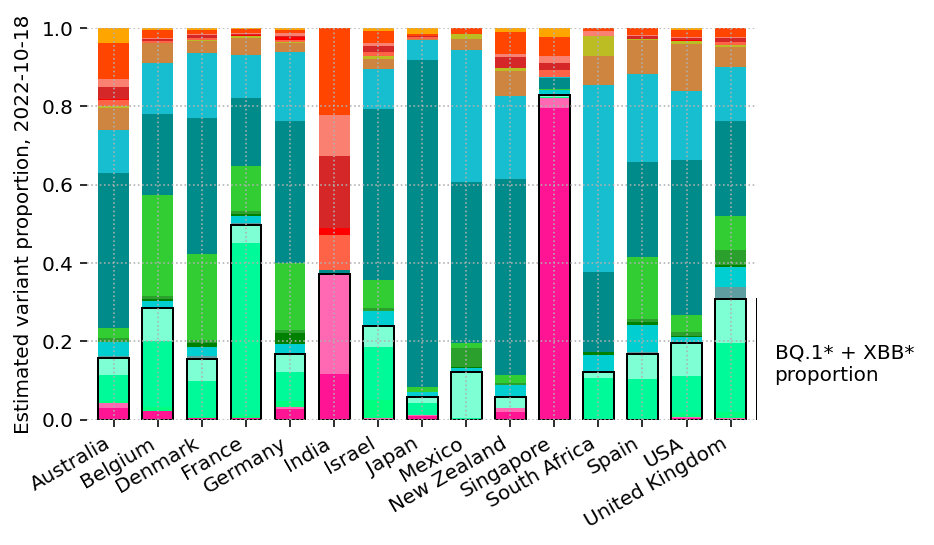

In [41]:
var_prop.loc[:,analysis_date,:].iloc[:,::-1].drop(index='Brazil')\
        .plot.bar(stacked=True, 
                   color=[lineage_colors[x] for x in merged_lineages_alias][::-1],
                   legend=False,
                   figsize=(6,4), width=0.7)
var_prop.loc[:,analysis_date,:].iloc[:,-6:-1].sum(1).drop(index='Brazil')\
        .plot.bar(facecolor="None",alpha=1,edgecolor='k', ls="-", lw=1,width=0.7)
plt.xlabel('')
plt.ylabel(f'Estimated variant proportion, {analysis_date}')
plt.gcf().autofmt_xdate()
plt.plot([14.6,14.6], [0., var_prop.loc[:,np.datetime64('today'),:].iloc[:,-6:-1].sum(1)['United Kingdom']], lw=1, color='k')
plt.text(15, 0.1, s='BQ.1* + XBB* \nproportion')
plt.ylim((0,1))
#plt.xlim(-.5,19)
plt.gcf().savefig("plots/variant-share-bar.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

Conduct some visual checks for the quality of fits

In [42]:
def sliding_proportion(x,n, width=7):
    c = np.repeat(1./width,width)
    return np.convolve(c,x, mode='same') / (np.convolve(c,n, mode='same') + 1e-16)

In [43]:
p = np.quantile(model.get_probabilities().squeeze(), (0.05,0.5,0.95),0)

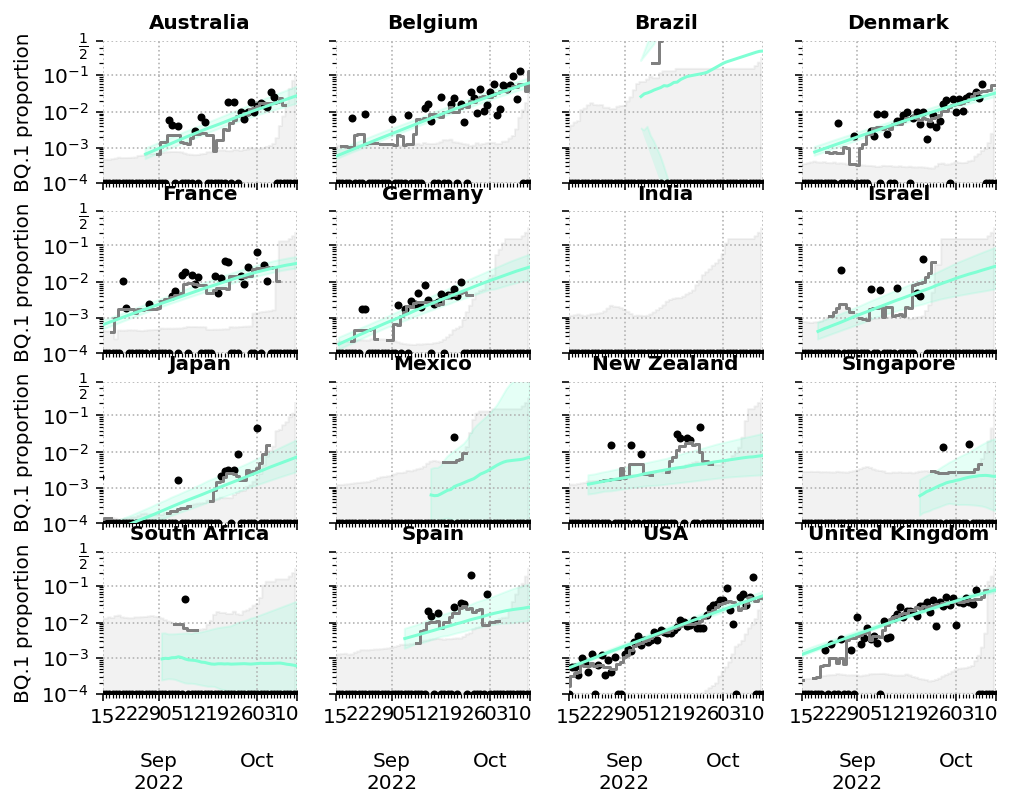

<Figure size 432x288 with 0 Axes>

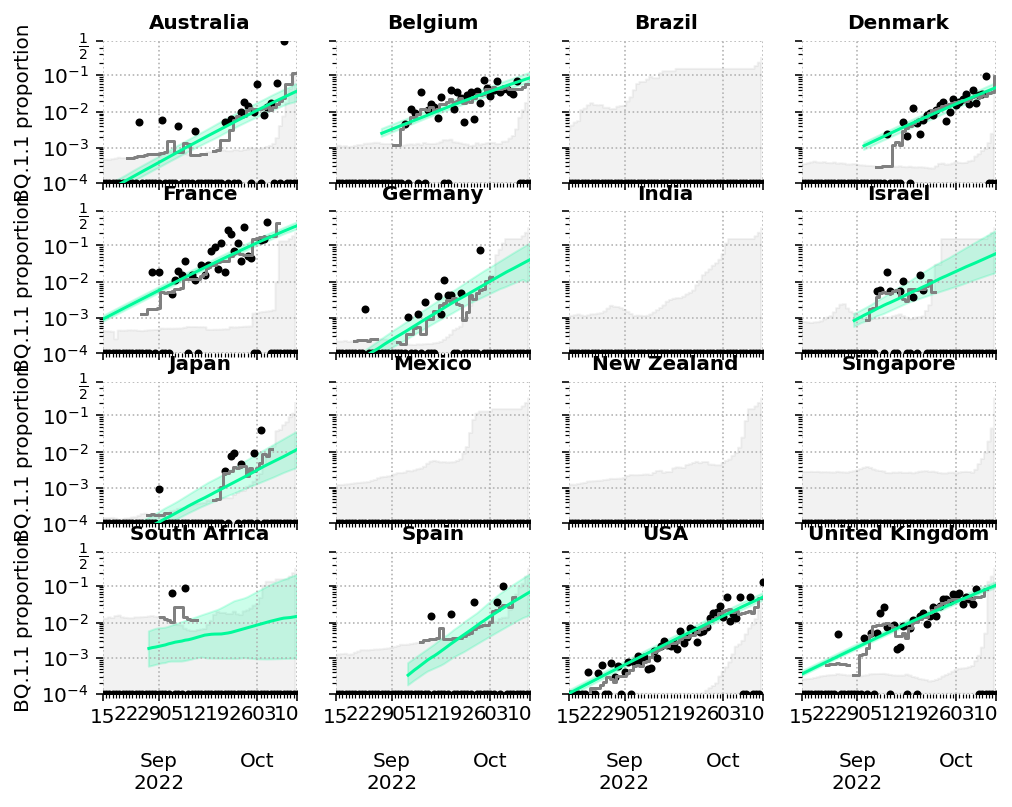

<Figure size 432x288 with 0 Axes>

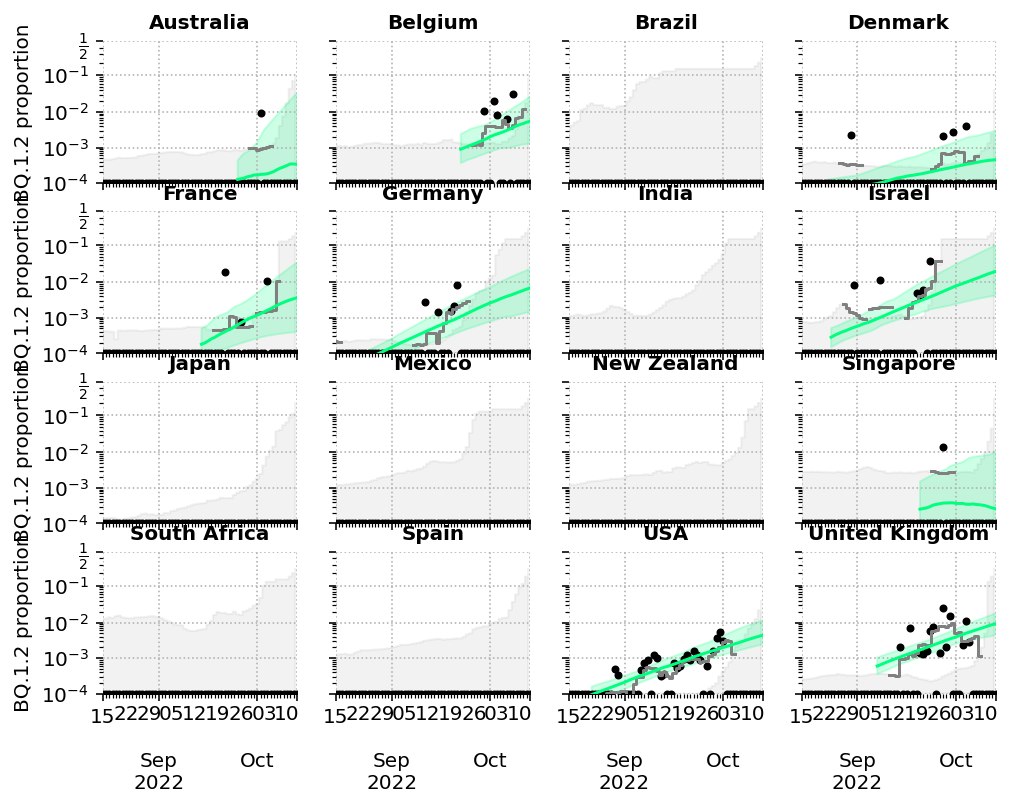

<Figure size 432x288 with 0 Axes>

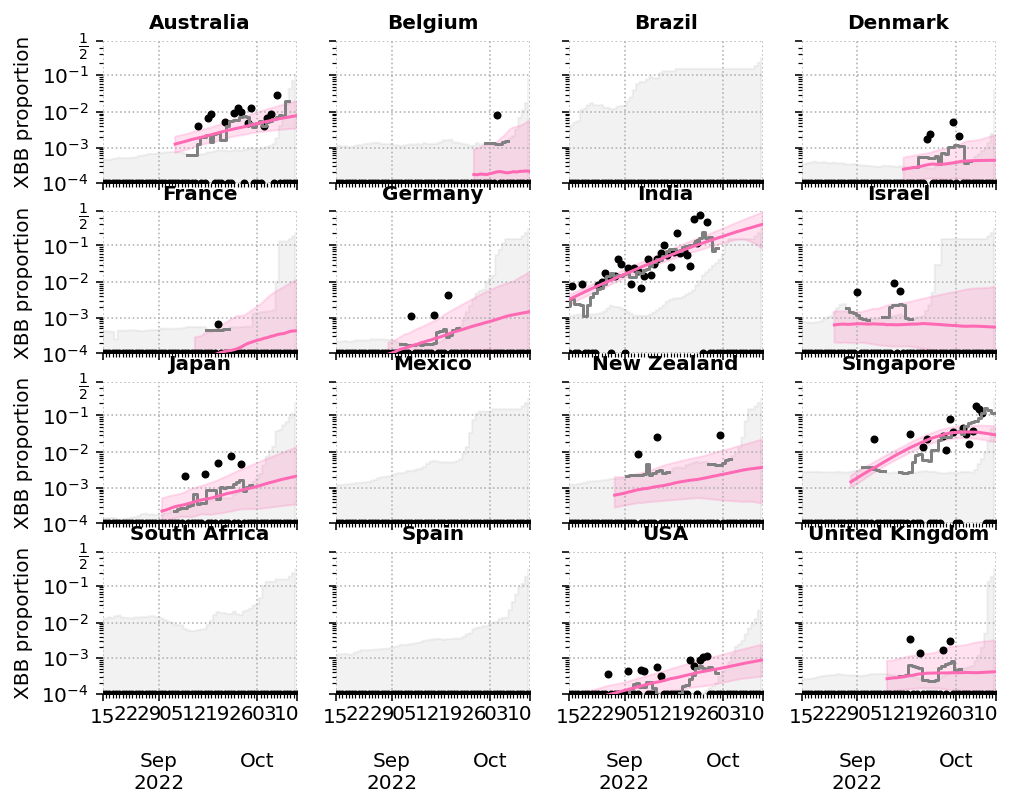

<Figure size 432x288 with 0 Axes>

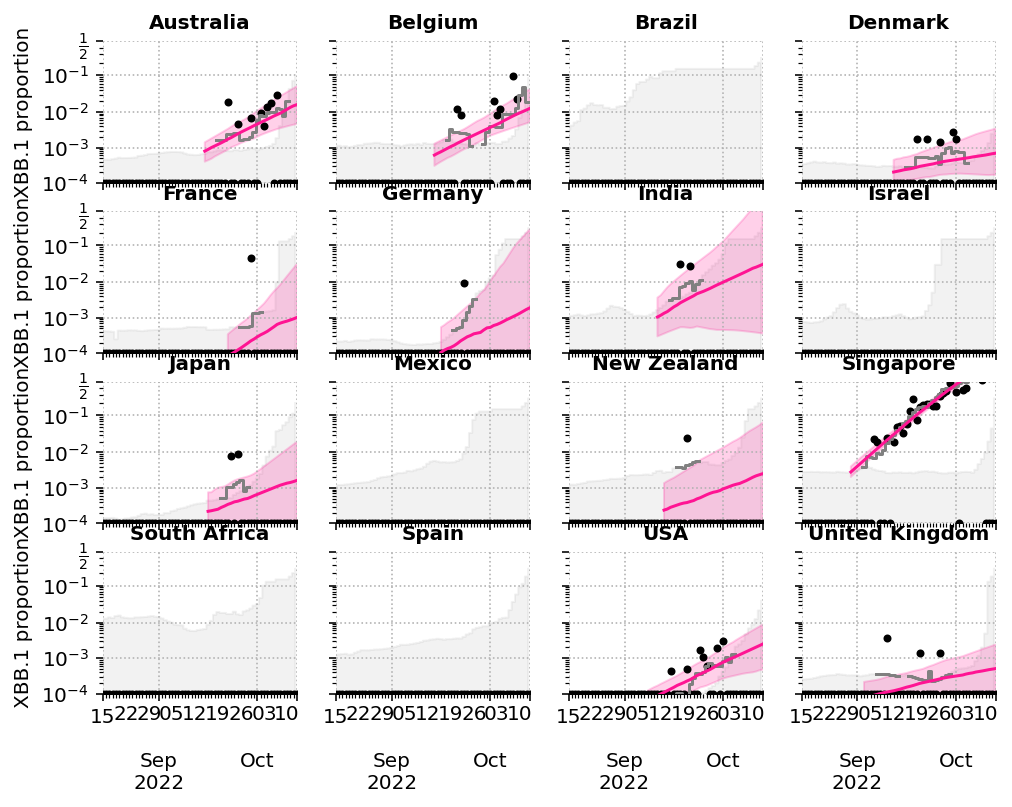

<Figure size 432x288 with 0 Axes>

In [44]:
#plt.plot(GG[-1,:,-1]/GG[-1].sum(-1))
#plt.plot(GG[-1,:,0]/GG[-1].sum(-1))
#plt.plot(GG[-1,:,1]/GG[-1].sum(-1))
#plt.plot(GG[-1,:,-3]/GG[-1].sum(-1))
#plt.plot(GG[-1,:,1]/GG[-1].sum(-1))
for v in ['BQ.1','BQ.1.1','BQ.1.2','XBB','XBB.1']:
    fig, ax = plt.subplots(4,4, figsize=(8,6),sharex=True, sharey=True)
    axs = ax.flatten()
    #v = "BQ.1.1"
    for i,b in enumerate(genomes.index.levels[0]):
        t = genomes.index.levels[1][0] + np.arange(p.shape[2]).astype('timedelta64[D]')
        a = axs[i]
        pd.Series(np.nan, index=t).plot(ax=a, label="")
        w = i#cases_land.index.to_list().index(b)
        a.plot(t[:GG.shape[1]],(GG[w,:,merged_lineages_alias.index(v)]/(GG[w].sum(-1)+1e-16) + 1e-4), ls="", marker=".", c='k', label='daily prop')
        a.plot(t[:GG.shape[1]], sliding_proportion(GG[w,:,merged_lineages_alias.index(v)], GG[w].sum(-1)), ds='steps-mid', c='grey', label='7d avg')
        y = 1./np.convolve(np.repeat(1./7,7), GG[w].sum(-1)+1, 'same')/7
        a.fill_between(x=np.repeat(t[:GG.shape[1]],2)[1:]-np.timedelta64(12,"h"), y1=1e-4, y2=np.repeat(y,2)[:-1], color='grey', zorder=-1, alpha=0.1, label='det. limit')
        a.plot(t, p[1,w,:,merged_lineages_alias.index(v)], c=lineage_colors[v], label='model fit')
        a.fill_between(x=t, y1=p[0,w,:,merged_lineages_alias.index(v)], y2=p[2,w,:,merged_lineages_alias.index(v)], color=lineage_colors[v], alpha=0.2)
        #plt.plot(GG[-1,:,merged_lineages_alias.index("BQ.1")]/GG[-1].sum(-1), ls="", marker=".")
        #plt.plot(p[:,merged_lineages_alias.index("BQ.1")])
        a.set_xlim(("2022-08-15",None))
        a.set_ylim((1e-4,0.5))
        a.set_yscale('logit')
        a.set_title(b, fontsize=10, weight='bold')
        a.set_ylabel(f"{v} proportion")
        #
    #a.legend()
    plt.show()
    plt.tight_layout()

### Prepare output

In [89]:
var_prop_tab = (var_prop.loc[:,np.datetime64('today'),:]*100).round(1)[show_lineages].T.astype("str")
var_prop_tab[growth_rates.isna()] = "(" + var_prop_tab[growth_rates.isna()] + ")"
growth_rate_tab = growth_rates.astype('str') + "±" + (s.std(level=0).T * 100).round().astype('Int64').astype("str")
growth_rate_tab[growth_rates.isna()] = "<NA>"

In [108]:
with open('var/README_template.md','r') as f:
    lines = f.read()
with open('README.md','w') as f:
    f.write(lines.format(date=analysis_date, growth_rate_tab=growth_rate_tab.to_html(), baseline=baseline, var_prop_tab=var_prop_tab.to_html()))